# Momento Evaluativo 2

# Modelo prescriptivo para la mejora del score crediticio personalizado


**Integrantes:**
- Alan Stiven Camacho Restrepo
- Isabel Cristina Suárez Roldán.

### Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Carga de la base de datos

In [2]:
# Lista vacía para guardar los DataFrames
dfs = []

# Leer archivos del 0 al 10 y agregarlos a la lista
for i in range(11):
    file_name = f"base_variables_totales_parte{i}.parquet"
    df = pd.read_parquet(file_name)
    dfs.append(df)

In [3]:
# Tabla final: Unir todos los DataFrames en uno solo
df_final = pd.concat(dfs, ignore_index=True)

In [4]:
# Tamaño de la tabla
df_final.shape

(1598523, 92)

In [5]:
df_final.head()

,fecha_orden,year,month,tipo_doc,cod_estado_cli,num_doc,cod_segm,dias_mora,desempleado,ingreso_final_smmlv,...,flag_estabilidad_6m_asto_total,flag_retiro_efectivo_bajo_ingreso_final,flag_retiro_efectivo_bajo_estimadores,cupo_smmlv,val_trx_cop_compra_smmlv,val_trx_cop_avance_smmlv,flag_avances_cupo_uso_tdc,razon_trx_max_una_cuota_ingreso_estimadores,flag_mal_uso_tdc_trx_max_ingreso_estimadores,valor_g
0,202104,2021,4,1,1,045b809be3,4,NaN,1.0,0.039338,...,1,0,0,None,None,None,0,None,0,G7
1,202402,2024,2,1,1,f25a890f5a,4,NaN,0.0,0.000000,...,1,0,0,None,None,None,0,None,0,G1
2,202408,2024,8,1,1,d58acc33de,M,178.0,NaN,0.000000,...,1,0,0,0.25384615384615385,None,None,0,None,0,G8
3,202210,2022,10,1,1,c1325d3a5b,4,0.0,NaN,0.480417,...,1,1,1,None,None,None,0,None,0,G5
4,202207,2022,7,1,1,1980a06c65,4,NaN,0.0,3.585892,...,1,0,0,None,None,None,0,None,0,G4


### Descripción de la tabla final

La tabla final es una base consolidada y anonimizada que resume el comportamiento financiero mensual de clientes del banco entre agosto de 2021 y marzo de 2025. Integra información de ingresos, gastos, productos financieros, uso de canales, estabilidad económica y riesgo crediticio. Contiene variables originales y derivadas, construidas a partir de 12 tablas cruzadas por cliente y fecha, con múltiples transformaciones, agregaciones y banderas (flags) para facilitar el análisis prescriptivo y la personalización del score crediticio.


### Distribución de columnas según el tipo de dato

La base de datos contiene algunas columnas que no serán utilizadas en el análisis inicial, por lo tanto, no son consideradas para esta primera estapa de desarrollo. No obstante, estas no serán eliminadas por completo, ya que podrían resultar útiles en análisis posteriores. Además, existen columnas consideradas no importantes desde el punto de vista estadístico —como fecha, tipo_doc y doc—, pero que se mantienen debido a que son identificadores clave para el cruce de tablas

In [6]:
# columnas no relevantes para el modelamiento
columnas_no_importantes = [
    'fecha_orden', 'year', 'month', 'tipo_doc', 
    'cod_estado_cli', 'num_doc', 'cod_segm'
]

In [7]:
columnas_no_utilizadas = [
    'fuente_ingreso_final_smmlv', 'supervivencia', 'probabilidad_contagio', 'potencial_contagio_mes',
    'susceptibilidad_mes', 'flag_regla_sobreendeudamiento', 'flag_regla_sobreendeudamiento_ce_ingreso_estimadores',
    'flag_regla_sobreendeudamiento_ci_ingreso_estimadores',
    'flag_regla_sobreendeudamiento_total_ingreso_estimadores', 'flag_regla_capacidad_pago', 'regla_razon_sobreendeudamiento',
    'regla_capacidad_pago'
]

In [8]:
# Columnas que tienen 2 posibles valores
columnas_dicotomicas = [
    'desempleado', 'flag_compras_basicas',
    'flag_compras_no_basicas', 'flag_inversiones',
    'flag_sobreendeudamiento_ce', 'flag_sobreendeudamiento_ci',
    'flag_sobreendeudamiento_total',
    'flag_capacidad_pago_ce', 'flag_capacidad_pago_ci',
    'flag_capacidad_pago_total',
    'flag_capacidad_pago_ce_estimadores',
    'flag_capacidad_pago_ci_estimadores',
    'flag_capacidad_pago_total_estimadores', 'estabilidad_mensual',
    'estabilidad_mensual_estimadores', 'flag_estabilidad_ingreso',
    'flag_estabilidad_ingreso_estimadores', 'flag_cuenta_cero',
    'flag_cliente_ahorra', 'flag_cliente_ahorra_estimadores',
    'flag_estabilidad_mensual_compras_basicas',
    'flag_estabilidad_mensual_compras_no_basicas',
    'flag_estabilidad_mensual_suma_basicas_no_basicas',
    'flag_estabilidad_mensual_gasto_total',
    'flag_estabilidad_6m_compras_basicas',
    'flag_estabilidad_6m_compras_no_basicas',
    'flag_estabilidad_6m_suma_basicas_no_basicas',
    'flag_estabilidad_6m_asto_total',
    'flag_retiro_efectivo_bajo_ingreso_final',
    'flag_retiro_efectivo_bajo_estimadores',
    'flag_avances_cupo_uso_tdc',
    'flag_mal_uso_tdc_trx_max_ingreso_estimadores'
]

In [9]:
len(columnas_dicotomicas)

32

In [10]:
# variable respuesta o target inicial para el proyecto
columna_categorica = ["valor_g"]

In [11]:
columnas_numericas = list(
    set(df_final.columns) - \
    (set(columnas_no_importantes) | set(columnas_no_utilizadas) | set(columnas_dicotomicas) | set(columna_categorica))
)

In [12]:
len(columnas_numericas)

40

In [13]:
columnas_numericas = [
    # 1. Cuotas / Endeudamiento
        'cuota_total_ce_smmlv',
        'cuota_total_ci_smmlv',
        'razon_sobreendeudamiento_ce',
        'razon_sobreendeudamiento_ci',
        'razon_sobreendeudamiento_total',
        'razon_sobreendeudamiento_ce_ingreso_estimadores',
        'razon_sobreendeudamiento_ci_ingreso_estimadores',
        'razon_sobreendeudamiento_total_ingreso_estimadores',

    # 2. Capacidad de pago
        'capacidad_pago_ce',
        'capacidad_pago_ci',
        'capacidad_pago_total',
        'capacidad_pago_ce_estimadores',
        'capacidad_pago_ci_estimadores',
        'capacidad_pago_total_estimadores',

    # 3. Ingresos / Estimaciones / Cupo
        'ingreso_final_smmlv',
        'valor_ingreso_estimadores_smmlv',
        'cupo_smmlv',

    # 4. Consumo / Compras / Transacciones
        'compras_basicas',
        'compras_no_basicas',
        'razon_compras_basicas',
        'razon_compras_no_basicas',
        'mnt_trx_var_smmlv',
        'mnt_trx_cat_tdc',
        'mnt_trx_cat_tdd',
        'mnt_trx_cat_retiros',
        'gasto_total',
        'val_trx_cop_compra_smmlv',
        'val_trx_cop_avance_smmlv',
        'razon_trx_max_una_cuota_ingreso_estimadores',
        'razon_retiro_efectivo_ingreso_final',
        'razon_retiro_efectivo_estimadores',

    # 5. Ahorros / Saldo
        'dbal_sld_cta_aho_smmlv',
        'dbal_sld_max_aho_smmlv',
        'dbal_sld_min_aho_smmlv',
        'vdbal_stddev_sld_dia_mes_cta_aho_smmlv',
        'vdbal_coef_var_sld_mes_cta_aho_smmlv',
        'razon_ahorro_cliente',
        'razon_ahorro_cliente_estimadores',

    # 6. Inversión / Mora
        'cnt_total_inversiones',
        'dias_mora'
]


In [14]:
len(columnas_numericas)

40

### Exploración de variables numéricas y dicotómicas

En esta sección se presentan los histogramas de las variables numéricas y dicotómicas del conjunto de datos. Estas gráficas permiten identificar la distribución de los valores, presencia de sesgos, acumulación en ceros, posibles valores atípicos y desequilibrios en las variables binarias, lo cual orienta las decisiones de limpieza, transformación e imputación para el modelamiento posterior.


In [15]:
# Función para graficar histogramas univariadas de variables continuas
def graficar_histogramas_por_bloques(
    df: pd.DataFrame,
    columnas: list,
    n_cols: int = 4,
    por_bloque: int = 20,
    bins: int = 40,
    sample_size: int = 10_000_000
) -> None:
    """
    Grafica histogramas por bloques para variables numéricas.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de columnas numéricas a graficar.
        n_cols (int): Número de columnas por fila.
        por_bloque (int): Número de histogramas por figura (bloque).
        bins (int): Número de bins para el histograma.
        sample_size (int): Tamaño de la muestra si el DataFrame es muy grande.
    """

    # Muestreo si es necesario
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Asegurar solo columnas numéricas
    columnas = [col for col in columnas if pd.api.types.is_numeric_dtype(df[col])]

    total = len(columnas)
    for start in range(0, total, por_bloque):
        sub_cols = columnas[start:start + por_bloque]
        n = len(sub_cols)
        n_rows = -(-n // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(sub_cols):
            sns.histplot(df[col], bins=bins, ax=axes[i], kde=False, color='steelblue')
            axes[i].set_title(f"{col}")
            axes[i].set_xlabel("")
            axes[i].set_ylabel("Frecuencia")

        # Ocultar subplots vacíos
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Histogramas por bloque", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [16]:
# Función para graficas de barras de variables dicotomicas
def graficar_flags_dicotomicas(df: pd.DataFrame, 
                               columnas: list, 
                               por_bloque: int = 16, 
                               n_cols: int = 4) -> None:
    """
    Grafica columnas dicotómicas (tipo flag 0/1) mostrando proporción de 1s.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de columnas dicotómicas a graficar.
        por_bloque (int): Número de variables a mostrar por bloque.
        n_cols (int): Número de columnas por fila en el subplot.
    """
    total = len(columnas)
    for start in range(0, total, por_bloque):
        sub_cols = columnas[start:start + por_bloque]
        n = len(sub_cols)
        n_rows = -(-n // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(sub_cols):
            # Calcular proporción de 1s
            proporciones = df[col].value_counts(normalize=True).sort_index()
            proporciones = proporciones.reindex([0, 1], fill_value=0)

            sns.barplot(x=proporciones.index, y=proporciones.values, ax=axes[i])
            axes[i].set_title(f"{col}")
            axes[i].set_xticks([0, 1])
            axes[i].set_ylim(0, 1)
            axes[i].set_xlabel("Valor")
            axes[i].set_ylabel("Proporción")

        # Ocultar ejes vacíos
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Distribución de flags (0/1)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [5]:
# Convertir 4 columnas con valores de tipo Decimal a Float
cols = ['val_trx_cop_compra_smmlv',
        'val_trx_cop_avance_smmlv',
        'razon_trx_max_una_cuota_ingreso_estimadores', 
        'cupo_smmlv']
df_final[cols] = df_final[cols].astype(float) 

## Gráfica 1.

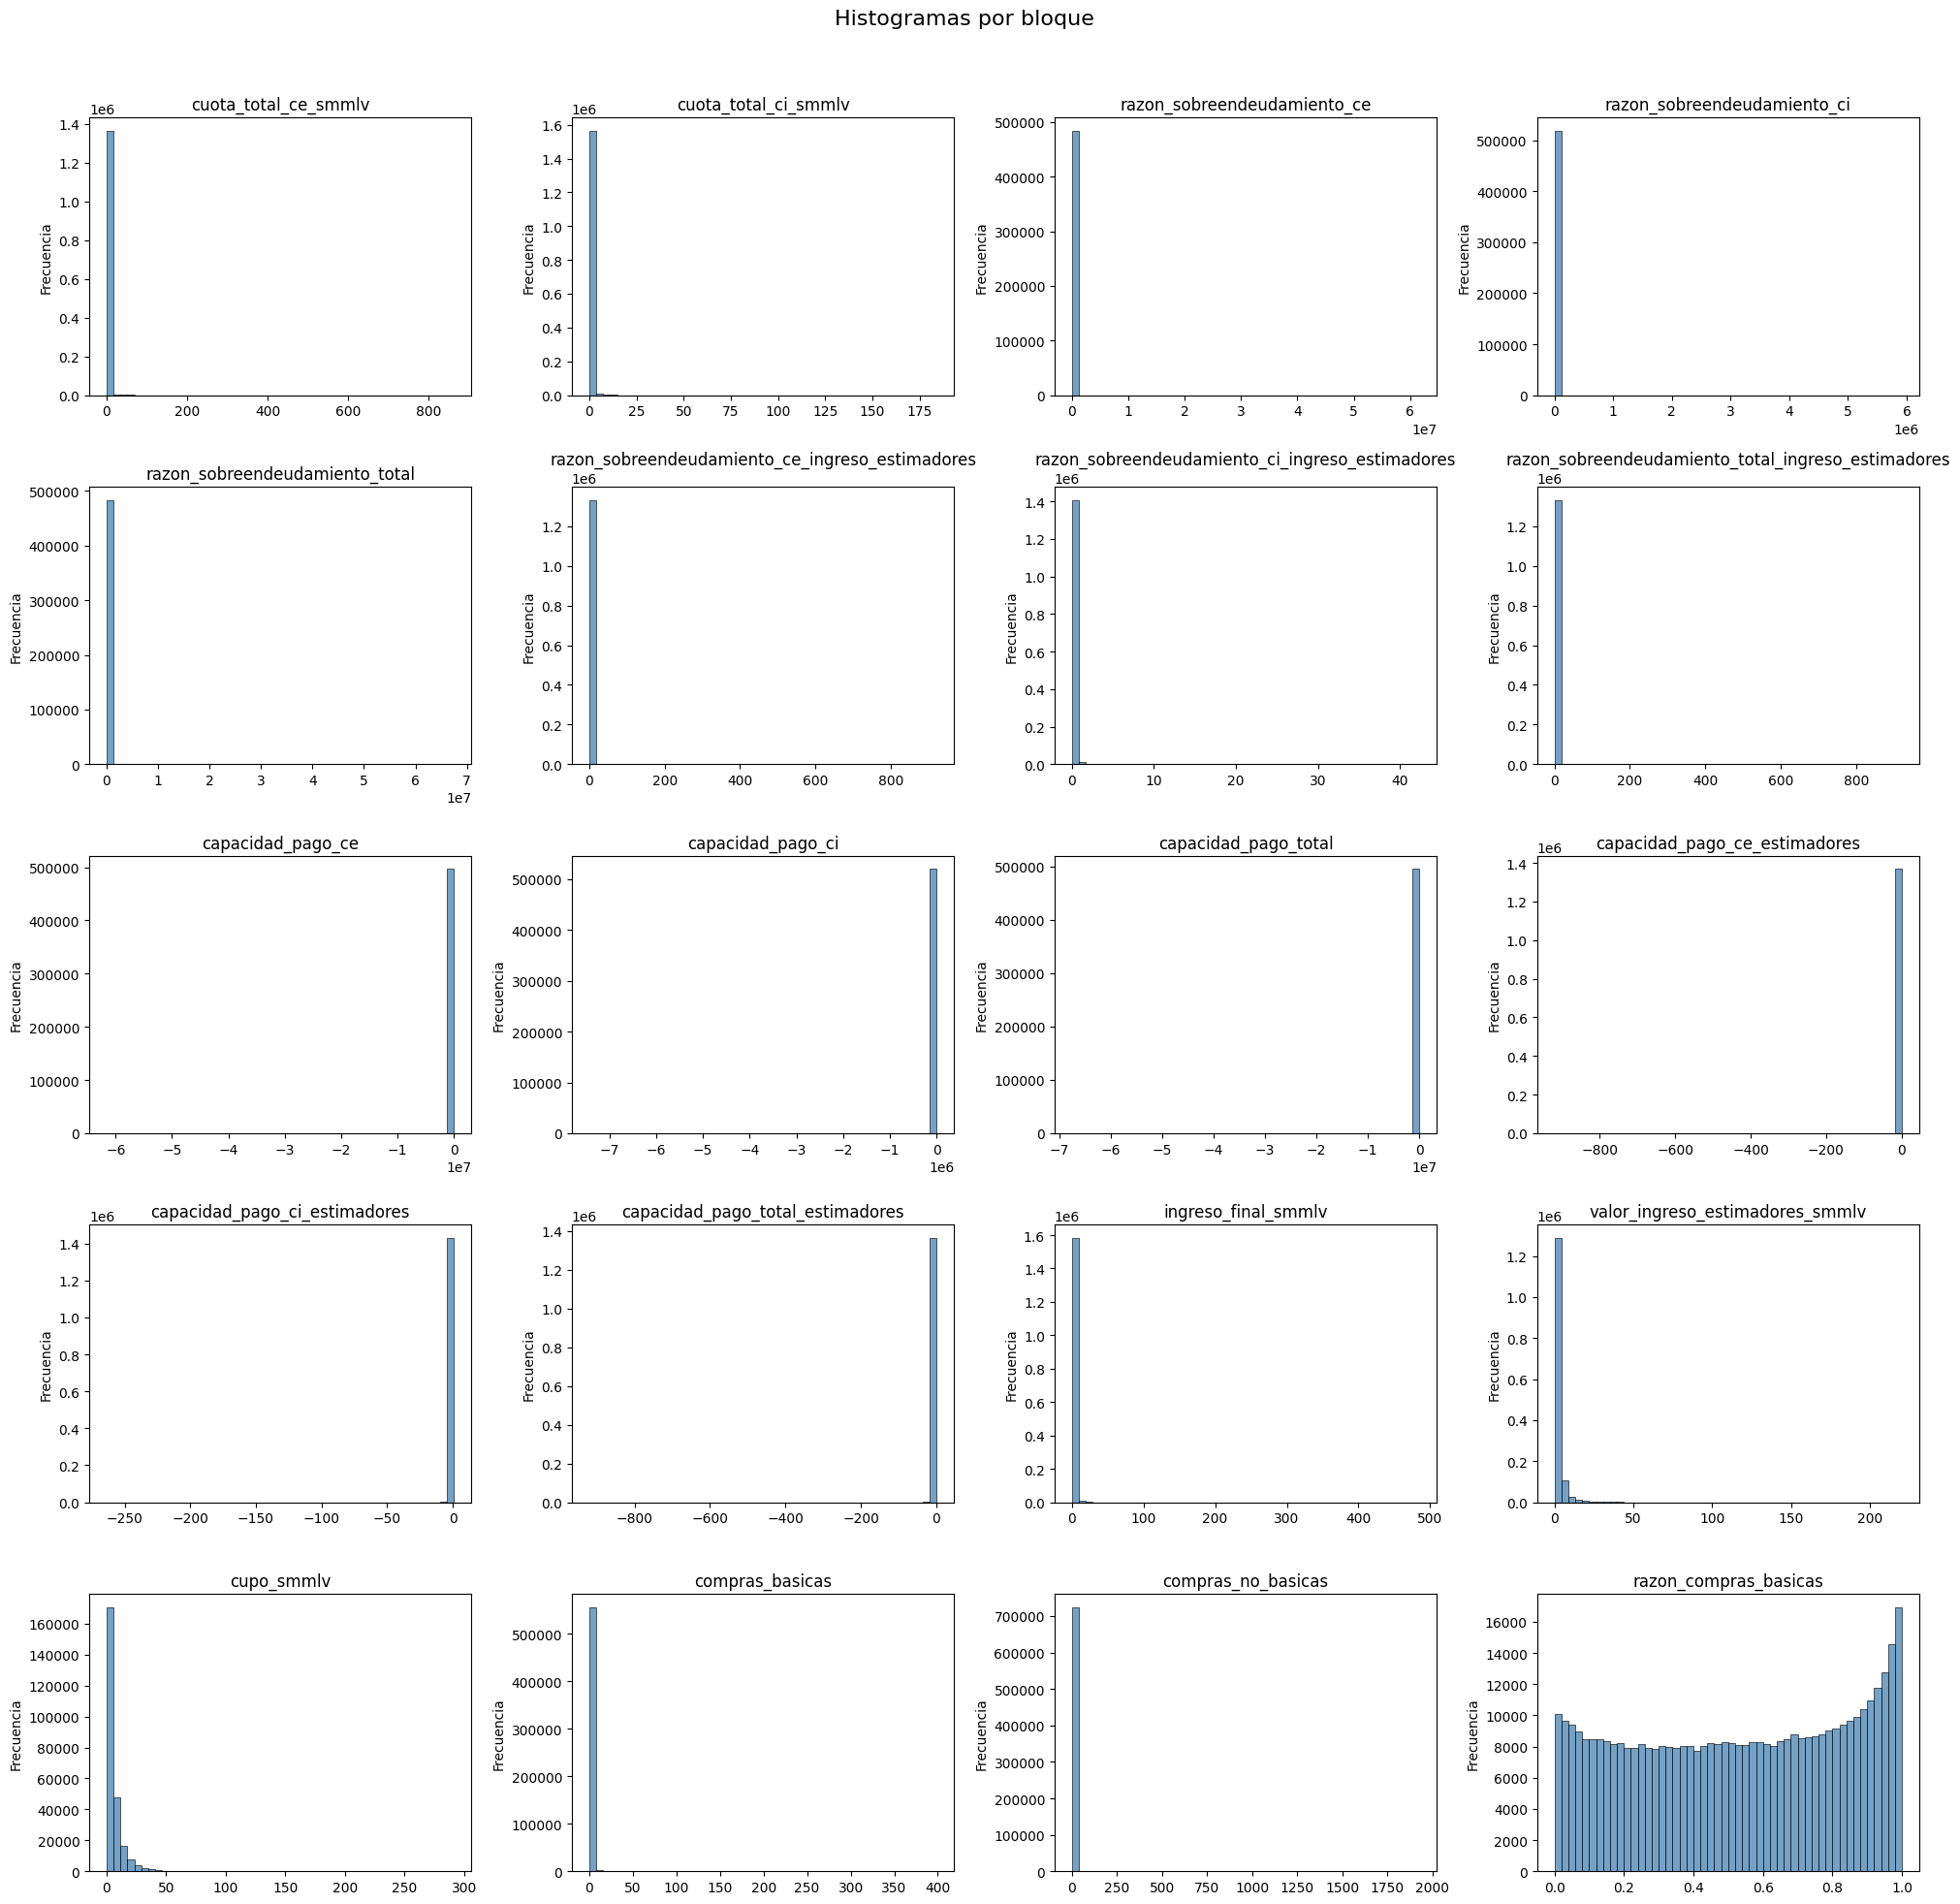

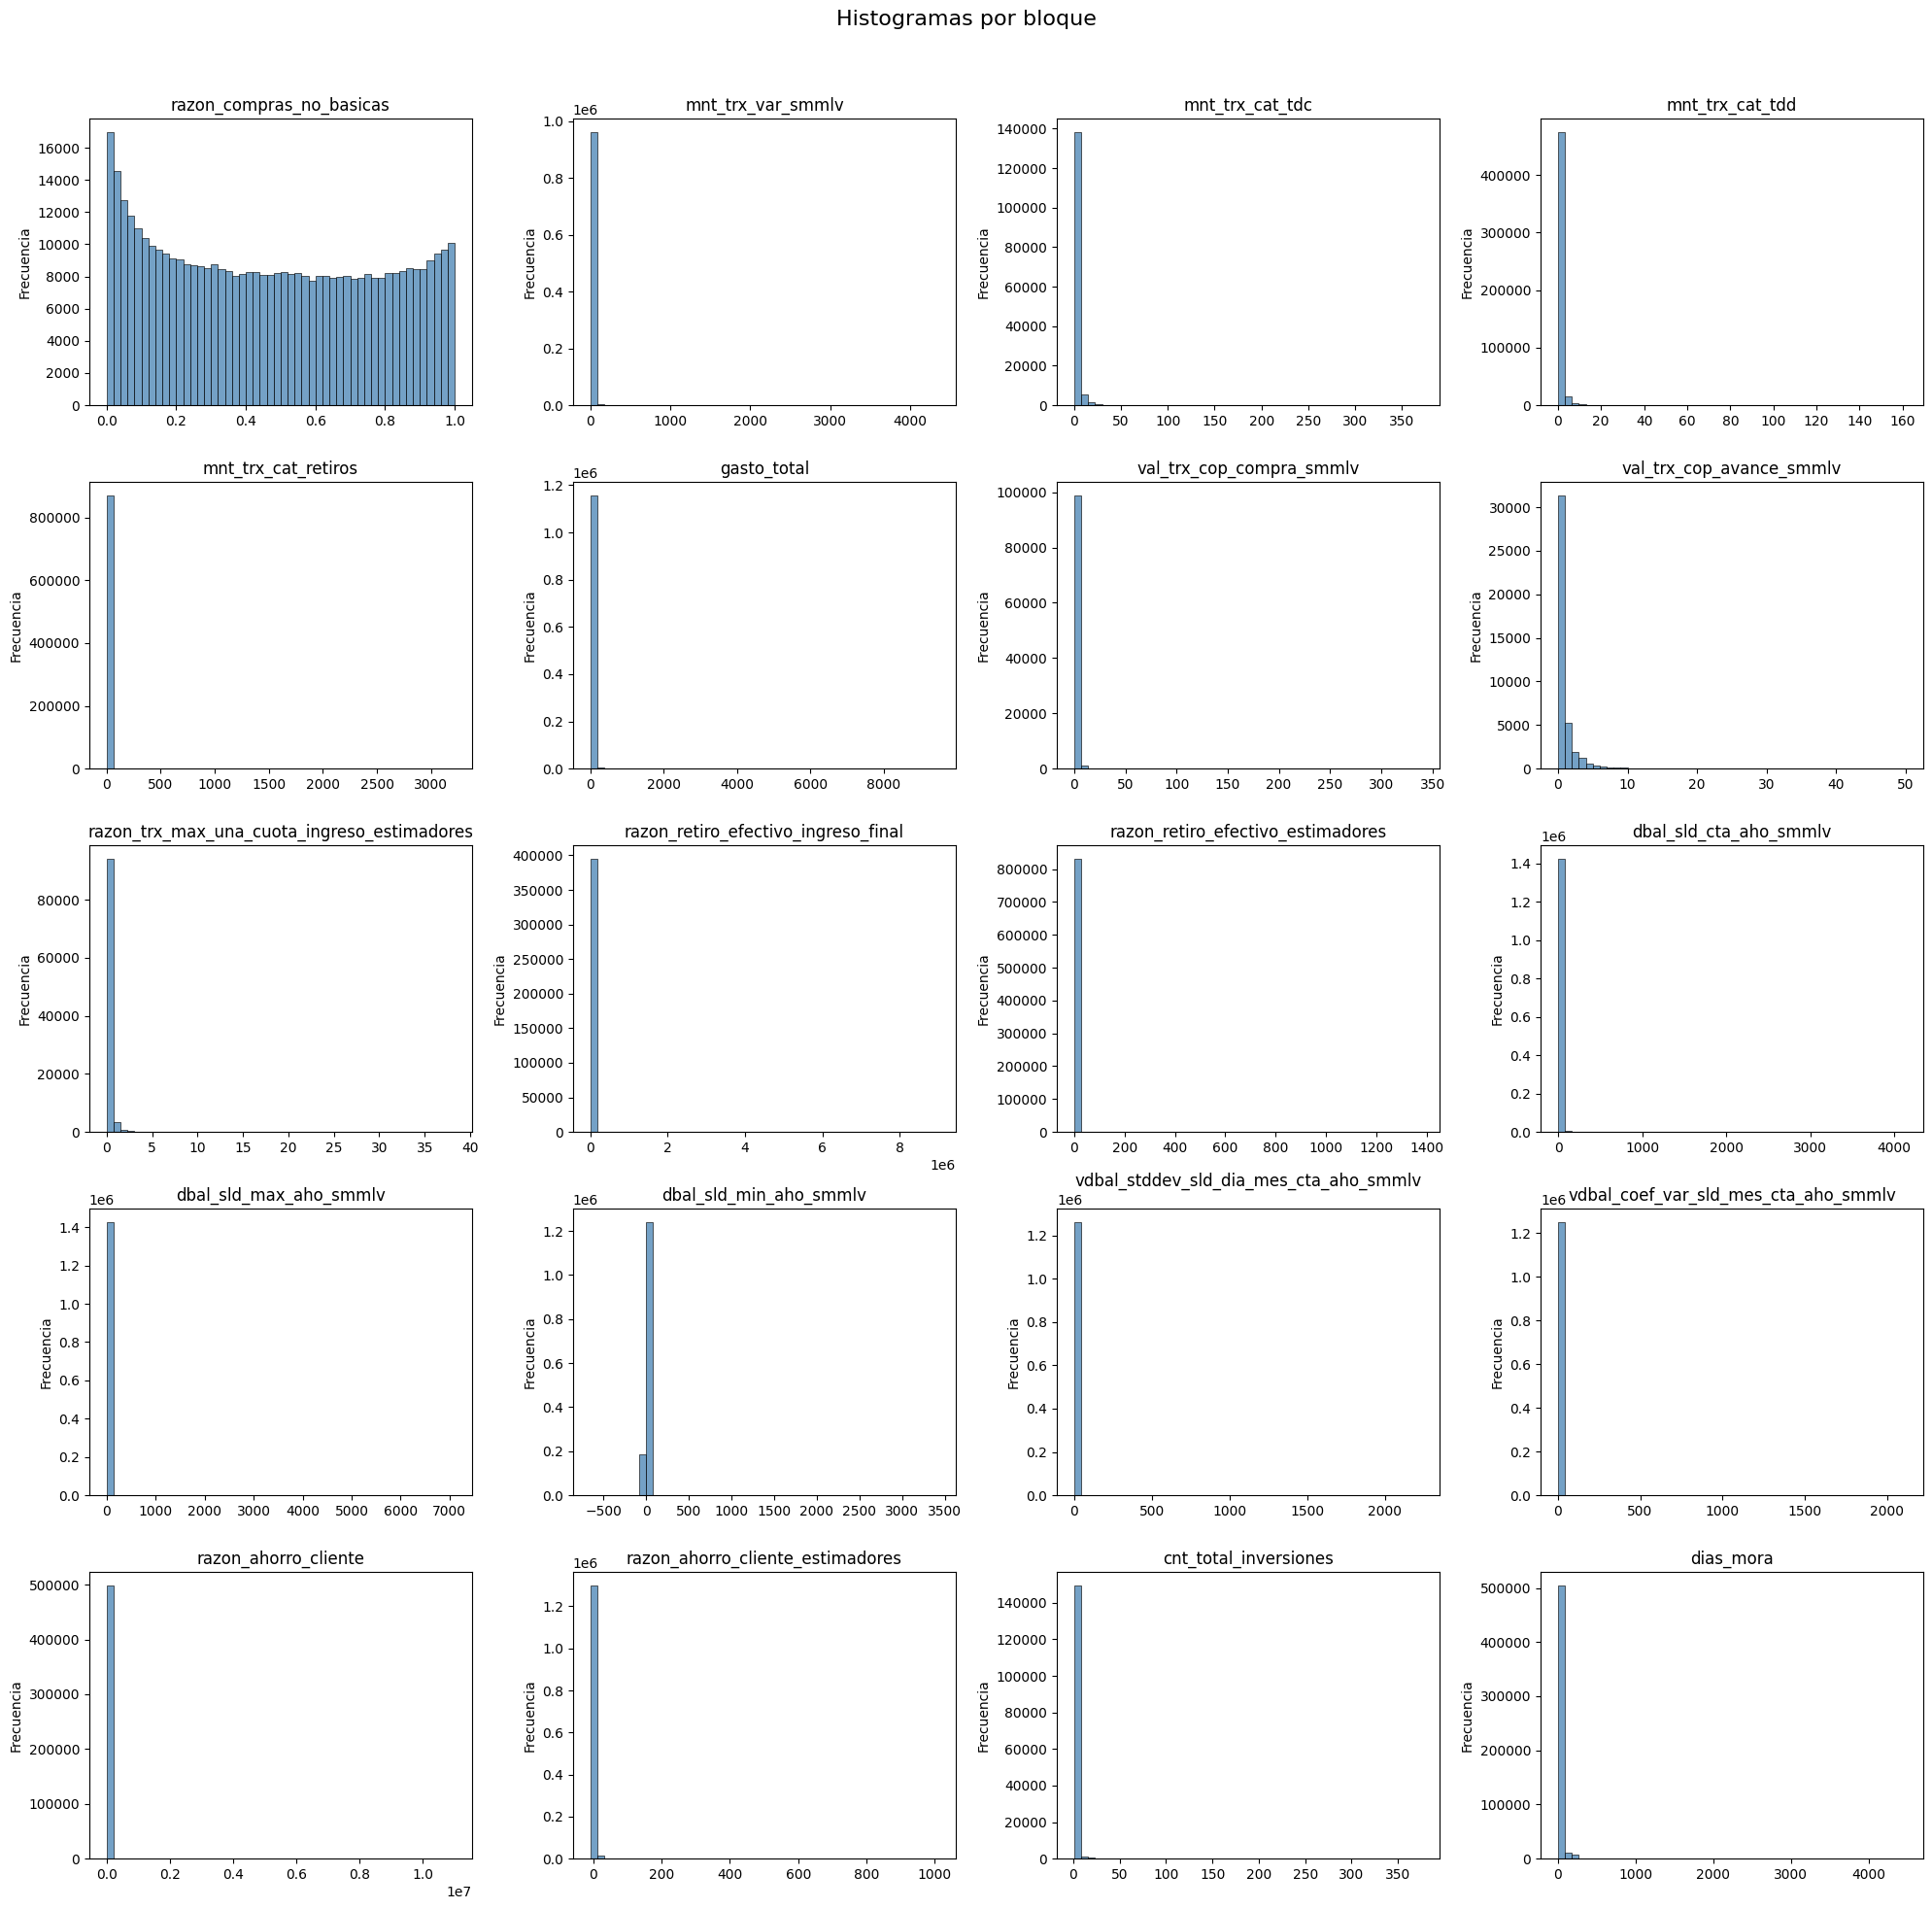

In [44]:
# Graficas de histogramas para las variables numericas continuas
graficar_histogramas_por_bloques(
    df=df_final,
    columnas=columnas_numericas,
    n_cols=4,
    por_bloque=20,
    bins=50
)

### Análisis de los histogramas

A partir de la gráfica anterior, se observa una fuerte asimetría positiva (sesgo a la derecha) en la mayoría de las
variables, con una gran concentración de los datos en valores cercanos a cero y una larga
cola hacia valores altos, lo que sugiere la presencia de valores atípicos o una dispersión
significativa en algunos casos. Variables como `cuota_total_ce_smmlv`,
`razon_sobreendeudamiento_total`, `gasto_total`, `mnt_trx_var_smmlv` y
`valor_ingreso_estimadores_smmlv` muestran este comportamiento de forma clara. También
se evidencian variables con posibles errores o valores negativos inusuales, como
`capacidad_pago_ce`, `capacidad_pago_total` o `dbal_sld_min_aho_smmlv`, donde los
histogramas presentan concentraciones en valores negativos que deben ser investigados.
Algunas variables como `razon_compras_basicas` y `razon_compras_no_basicas` presentan
distribuciones más uniformes o bimodales, indicando patrones de comportamiento más
variados. Adicionalmente, variables como `razon_ahorro_cliente`,
`razon_ahorro_cliente_estimadores`, `cnt_total_inversiones`, `dias_mora`,
`val_trx_cop_compra_smmlv`, `val_trx_cop_avance_smmlv`,
`razon_trx_max_una_cuota_ingreso_estimadores` y `cupo_smmlv` refuerzan esta tendencia de
asimetría positiva, con una marcada concentración en valores bajos y colas alargadas hacia
la derecha. Este patrón generalizado resalta la necesidad de aplicar transformaciones
adecuadas (por ejemplo, logarítmicas) y un tratamiento cuidadoso de outliers para mejorar
la representación de los datos y garantizar un mejor desempeño en los modelos predictivos
posteriores

## Gráfica 2.

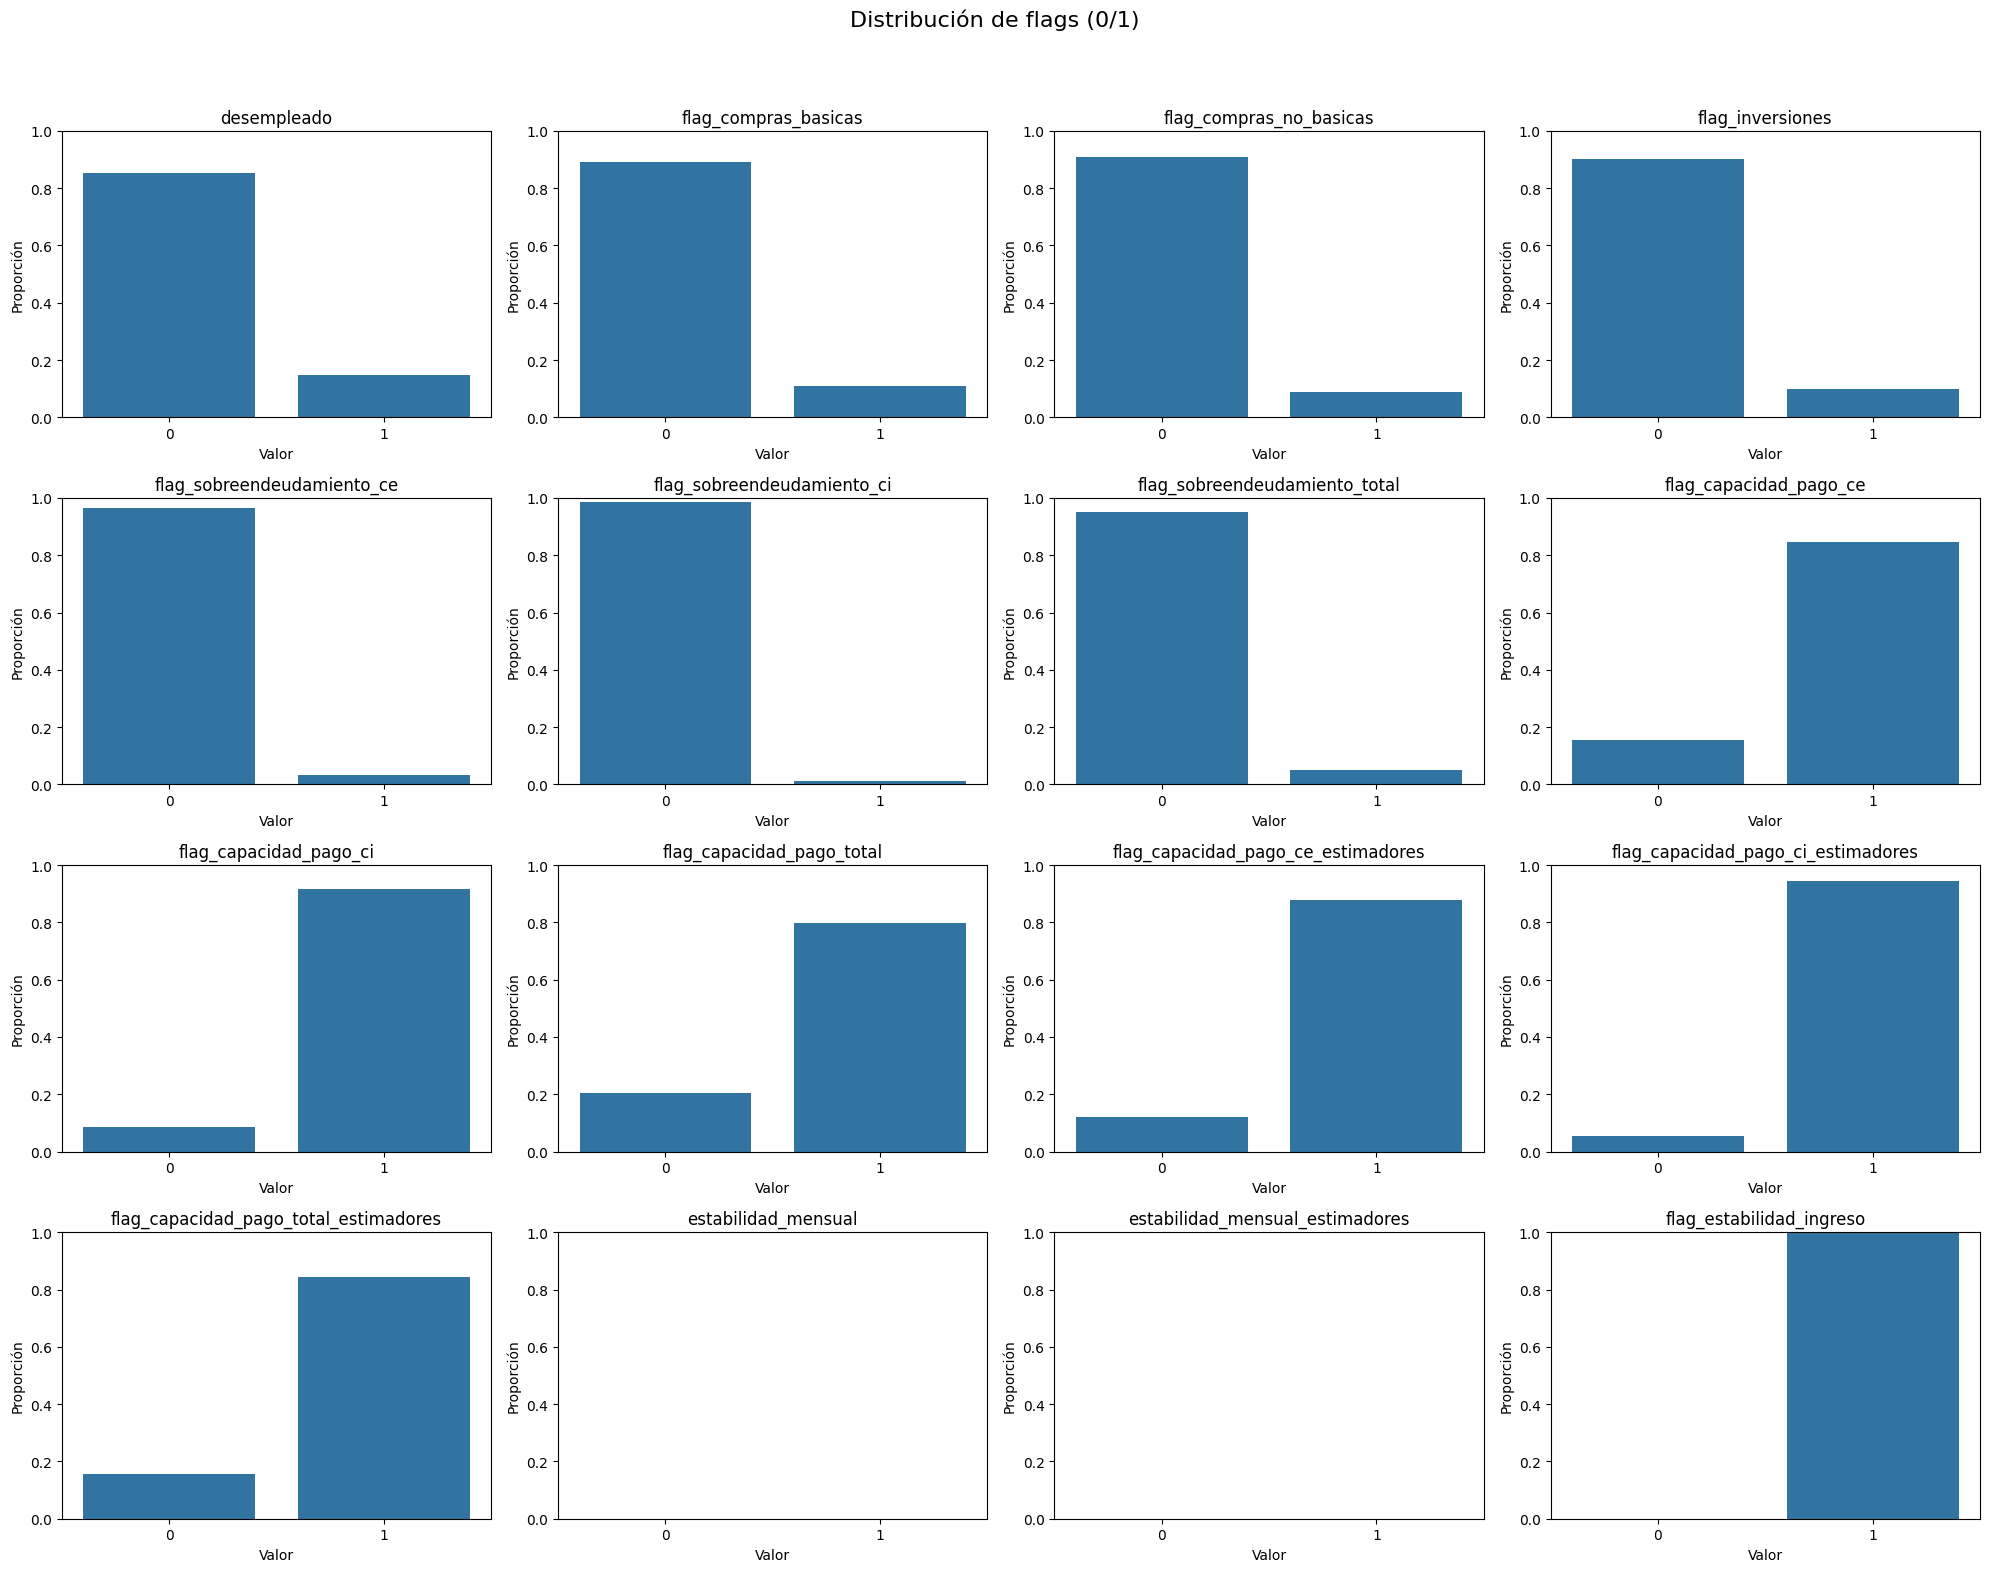

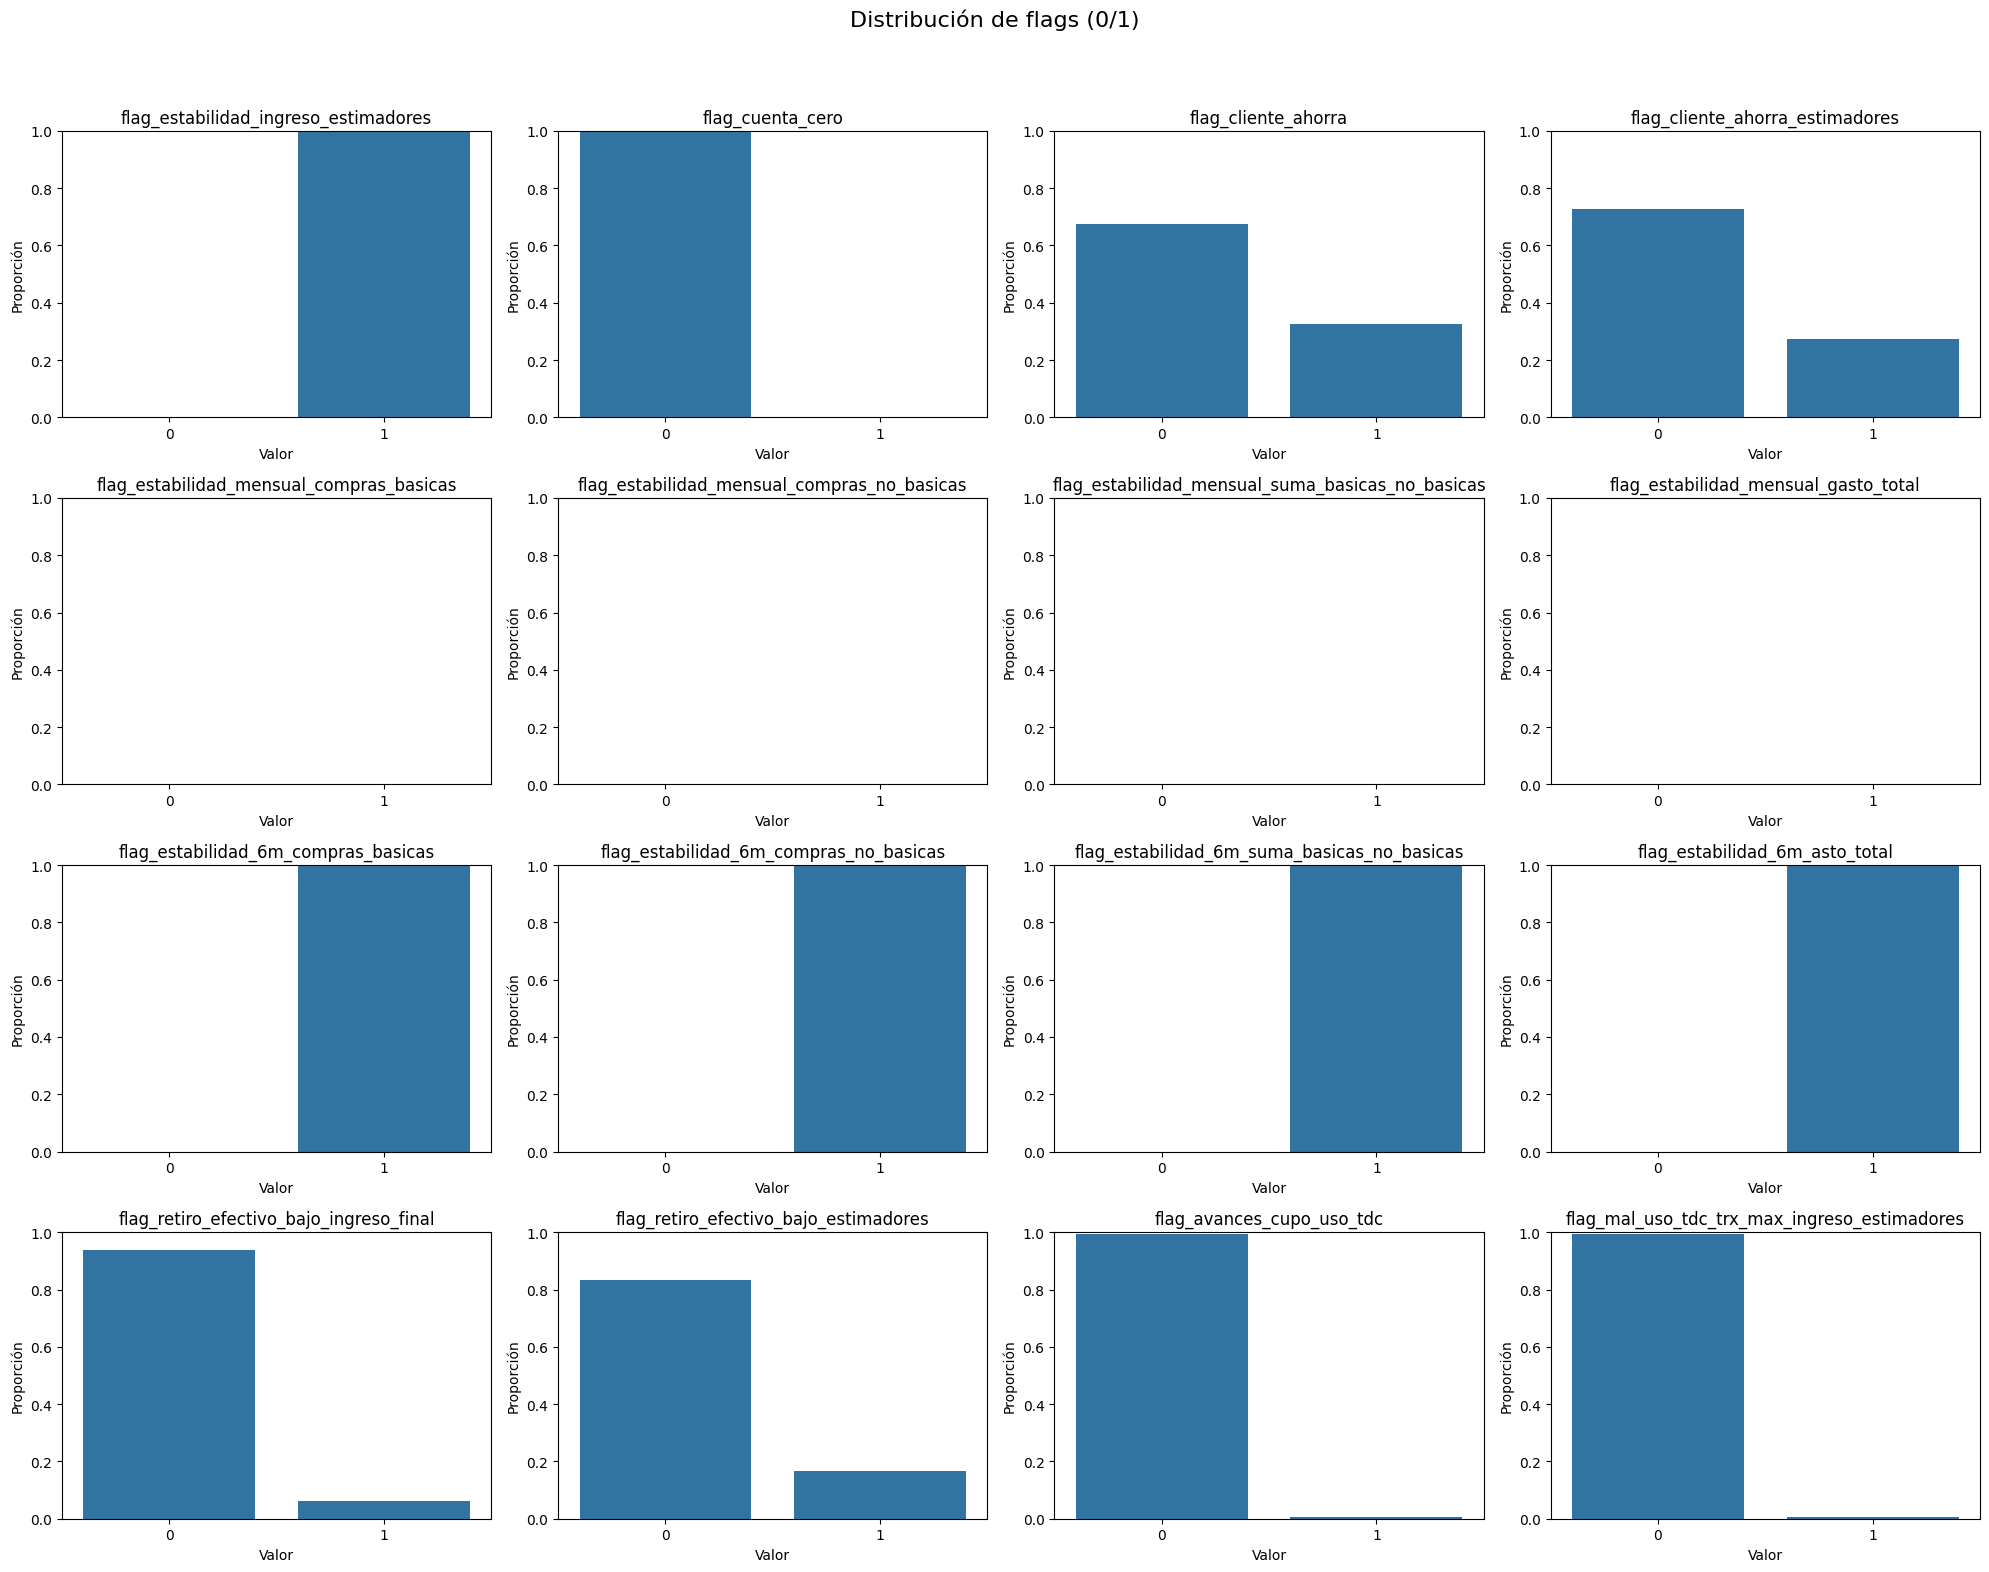

In [34]:
# Graficas de barras para las variables dicotomicas
graficar_flags_dicotomicas(df_final, columnas_dicotomicas, por_bloque=16, n_cols=4)

### Análisis de las gráficas de barras

En cuanto a las variables tipo flag, la mayoría presenta una marcada desproporción en su
distribución, evidenciando una alta concentración de observaciones en uno de los dos
valores posibles (0 o 1). Variables como `desempleado`, `flag_compras_basicas`,
`flag_inversiones` y `flag_sobreendeudamiento_total` muestran una clara predominancia del
valor 0, lo que indica que solo una fracción menor de los clientes se encuentra en estas
situaciones. Por otro lado, variables como `flag_capacidad_pago_ce`,
`flag_capacidad_pago_ci`, `flag_estabilidad_ingreso` y `flag_estabilidad_ingreso_estimadores`
presentan un predominio del valor 1, lo que sugiere una mayor estabilidad o capacidad de
pago estimada en gran parte de los clientes. Algunas variables como `flag_cliente_ahorra` y
sus estimadores exhiben distribuciones más balanceadas, lo que podría estar reflejando
patrones más diversos en el comportamiento financiero de los usuarios. En general, estas
distribuciones reflejan la heterogeneidad de la población analizada y resaltan la importancia
de considerar el desbalance en estas variables para evitar sesgos en modelos
supervisados, particularmente en algoritmos sensibles a clases mayoritarias

### Descripción de estadísticos básicos en las columnas númericas

In [69]:
df_final[columnas_numericas].describe()

,cuota_total_ce_smmlv,cuota_total_ci_smmlv,razon_sobreendeudamiento_ce,razon_sobreendeudamiento_ci,razon_sobreendeudamiento_total,razon_sobreendeudamiento_ce_ingreso_estimadores,razon_sobreendeudamiento_ci_ingreso_estimadores,razon_sobreendeudamiento_total_ingreso_estimadores,capacidad_pago_ce,capacidad_pago_ci,...,razon_retiro_efectivo_estimadores,dbal_sld_cta_aho_smmlv,dbal_sld_max_aho_smmlv,dbal_sld_min_aho_smmlv,vdbal_stddev_sld_dia_mes_cta_aho_smmlv,vdbal_coef_var_sld_mes_cta_aho_smmlv,razon_ahorro_cliente,razon_ahorro_cliente_estimadores,cnt_total_inversiones,dias_mora
count,1.371211e+06,1.576640e+06,4.837130e+05,5.187440e+05,4.836920e+05,1.335223e+06,1.425364e+06,1.335151e+06,4.968960e+05,5.203240e+05,...,8.316750e+05,1.427981e+06,1.427981e+06,1.427981e+06,1.260538e+06,1.248135e+06,4.980050e+05,1.316170e+06,152692.000000,525024.000000
mean,7.501247e-01,1.769019e-01,2.337563e+02,3.696290e+01,2.734072e+02,3.158695e-01,6.110023e-02,3.807634e-01,-2.563593e+02,-6.431343e+01,...,1.142744e+00,2.414205e+00,3.981564e+00,1.207290e+00,8.061169e-01,1.367431e+00,9.334523e+01,9.757339e-01,1.986063,12.398327
std,5.266180e+00,9.710907e-01,9.215976e+04,1.214282e+04,1.012896e+05,2.459053e+00,2.556014e-01,2.482214e+00,9.200066e+04,1.512503e+04,...,3.996777e+00,1.550493e+01,2.213195e+01,1.078068e+01,5.797825e+00,3.683259e+00,2.107287e+04,5.458348e+00,5.997925,72.085059
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.160500e+07,-7.429727e+06,...,9.041591e-09,-6.855490e+00,-5.836500e-01,-6.520590e+02,0.000000e+00,0.000000e+00,-1.514500e+03,-7.824811e+00,1.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.136728e-01,7.689141e-01,...,2.352941e-01,6.280000e-03,2.664000e-02,-8.700000e-04,2.512000e-02,3.076167e-01,2.982640e-02,7.005298e-03,1.000000,0.000000
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.943751e-02,0.000000e+00,0.000000e+00,0.000000e+00,9.028260e-01,9.694210e-01,...,6.329547e-01,1.031100e-01,6.366500e-01,4.900000e-04,1.840500e-01,9.877024e-01,1.338587e-01,7.782082e-02,1.000000,0.000000
75%,2.603448e-01,0.000000e+00,1.988921e-01,2.896981e-02,3.639603e-01,1.328883e-01,0.000000e+00,2.674662e-01,1.000000e+00,1.000000e+00,...,1.223217e+00,7.418700e-01,2.290780e+00,2.134000e-02,5.589000e-01,1.895703e+00,5.283600e-01,3.875395e-01,1.000000,1.000000
max,8.627698e+02,1.840604e+02,6.160500e+07,5.918346e+06,6.752335e+07,9.212567e+02,4.232705e+01,9.212567e+02,1.000000e+00,1.000000e+00,...,1.382058e+03,4.140199e+03,7.103069e+03,3.423263e+03,2.238336e+03,2.115000e+03,1.099957e+07,1.010224e+03,376.000000,4480.000000


In [24]:
# Proporción de los grupos de riesgo en el dataset (variable respuesta)
df_final["valor_g"].value_counts(1)

valor_g
G7    0.230965
G8    0.136281
G5    0.123376
G1    0.123342
G4    0.105175
G6    0.102139
G3    0.092522
G2    0.086201
Name: proportion, dtype: float64

## Gráfica 3.

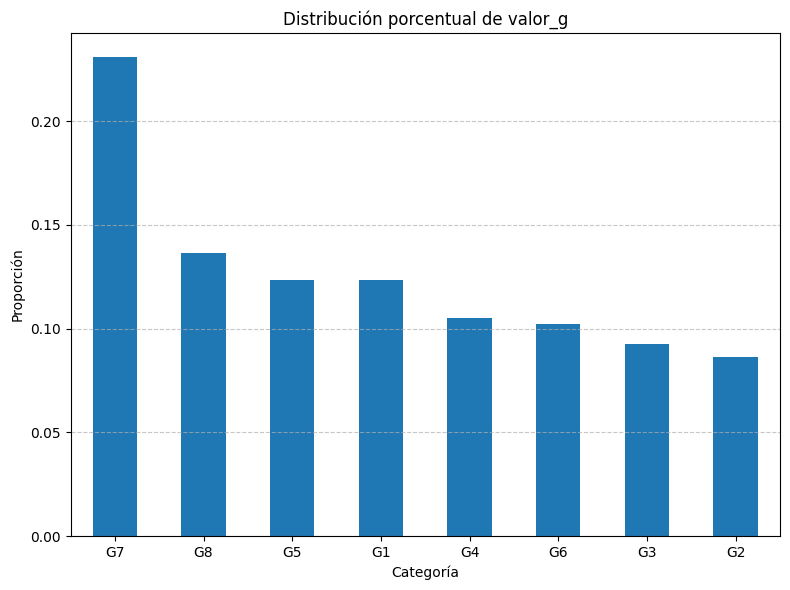

In [14]:
# Calcular la distribución porcentual de los valores en la columna "valor_g"
value_counts_percentage = df_final["valor_g"].value_counts(normalize=True)

# Graficar
plt.figure(figsize=(8, 6))
value_counts_percentage.plot(kind='bar')
plt.title('Distribución porcentual de valor_g')
plt.xlabel('Categoría')
plt.ylabel('Proporción')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


El análisis exploratorio de las estadísticas descriptivas permitió identificar comportamientos
financieros relevantes en la población estudiada. Se observó que la mayoría de los clientes
presenta cuotas mensuales internas y externas cercanas a cero (mediana = 0), lo cual
evidencia que un gran porcentaje no posee obligaciones crediticias activas. Sin embargo,
existen valores máximos atípicamente altos, con cuotas superiores a 800 salarios mínimos
legales vigentes (SMMLV), lo que sugiere la presencia de individuos altamente endeudados.
Las razones de sobreendeudamiento, tanto internas como externas, presentan
distribuciones con sesgo positivo, y una desviación estándar considerable, destacando la
heterogeneidad en la capacidad financiera de los clientes. Adicionalmente, las variables de
capacidad de pago muestran valores negativos en algunos casos, lo que implica que ciertos
clientes destinan más del 100% de sus ingresos mensuales estimados al pago de
obligaciones y consumo básico, indicando una situación crítica de liquidez. En cuanto al
ahorro, si bien la mediana de la razón de ahorro es cercana a cero, existen casos con
razones superiores a 10⁷, lo cual evidencia outliers probablemente asociados a clientes con
ingresos bajos pero con saldos elevados, o posibles inconsistencias en los datos. Además,
variables como la cantidad de inversiones realizadas y los días en mora refuerzan la
necesidad de una intervención personalizada, ya que si bien la media de días en mora es
baja, existen clientes con acumulados extremos superiores a 4.000 días, lo cual representa
un riesgo crediticio importante. Estos resultados respaldan la pertinencia del desarrollo de
un modelo prescriptivo que permita segmentar a los clientes con base en su situación
financiera real y ofrecer recomendaciones que favorezcan la mejora de su score crediticio.
Finalmente, en relación con la variable grupo de riesgo, el análisis evidenció una distribución relativamente balanceada de los clientes entre los distintos niveles, con proporciones similares en la mayoría de grupos. No obstante, el grupo G7 presenta una concentración ligeramente mayor de clientes en comparación con los demás. La incorporación del grupo de riesgo como variable categórica
permitirá al modelo prescriptivo priorizar recomendaciones según el perfil crediticio
individual.


### Gráficas Boxplots para columnas numéricas

Los boxplots permiten visualizar la dispersión, la mediana y los valores atípicos de cada variable numérica. Estas gráficas son útiles para detectar asimetrías, rangos extremos y posibles outliers que pueden afectar el desempeño de los modelos si no se tratan adecuadamente.


In [18]:
# Función para graficar Boxplots de variables continuas
def graficar_boxplots_por_bloques(
    df: pd.DataFrame,
    columnas: list,
    n_cols: int = 4,
    por_bloque: int = 20,
    sample_size: int = 10_000_000
) -> None:
    """
    Grafica boxplots por bloques para columnas numéricas.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de nombres de columnas numéricas.
        n_cols (int): Número de columnas por fila.
        por_bloque (int): Número de boxplots por bloque de visualización.
        sample_size (int): Tamaño máximo de muestra para acelerar gráficas.
    """
    # Muestreo si el DataFrame es muy grande
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Filtrar solo columnas numéricas
    columnas = [col for col in columnas if pd.api.types.is_numeric_dtype(df[col])]

    total = len(columnas)
    for start in range(0, total, por_bloque):
        sub_cols = columnas[start:start + por_bloque]
        n = len(sub_cols)
        n_rows = -(-n // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(sub_cols):
            sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
            axes[i].set_title(f"{col}")
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")

        # Ocultar ejes vacíos
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Boxplots por bloque", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


## Gráfica 4.

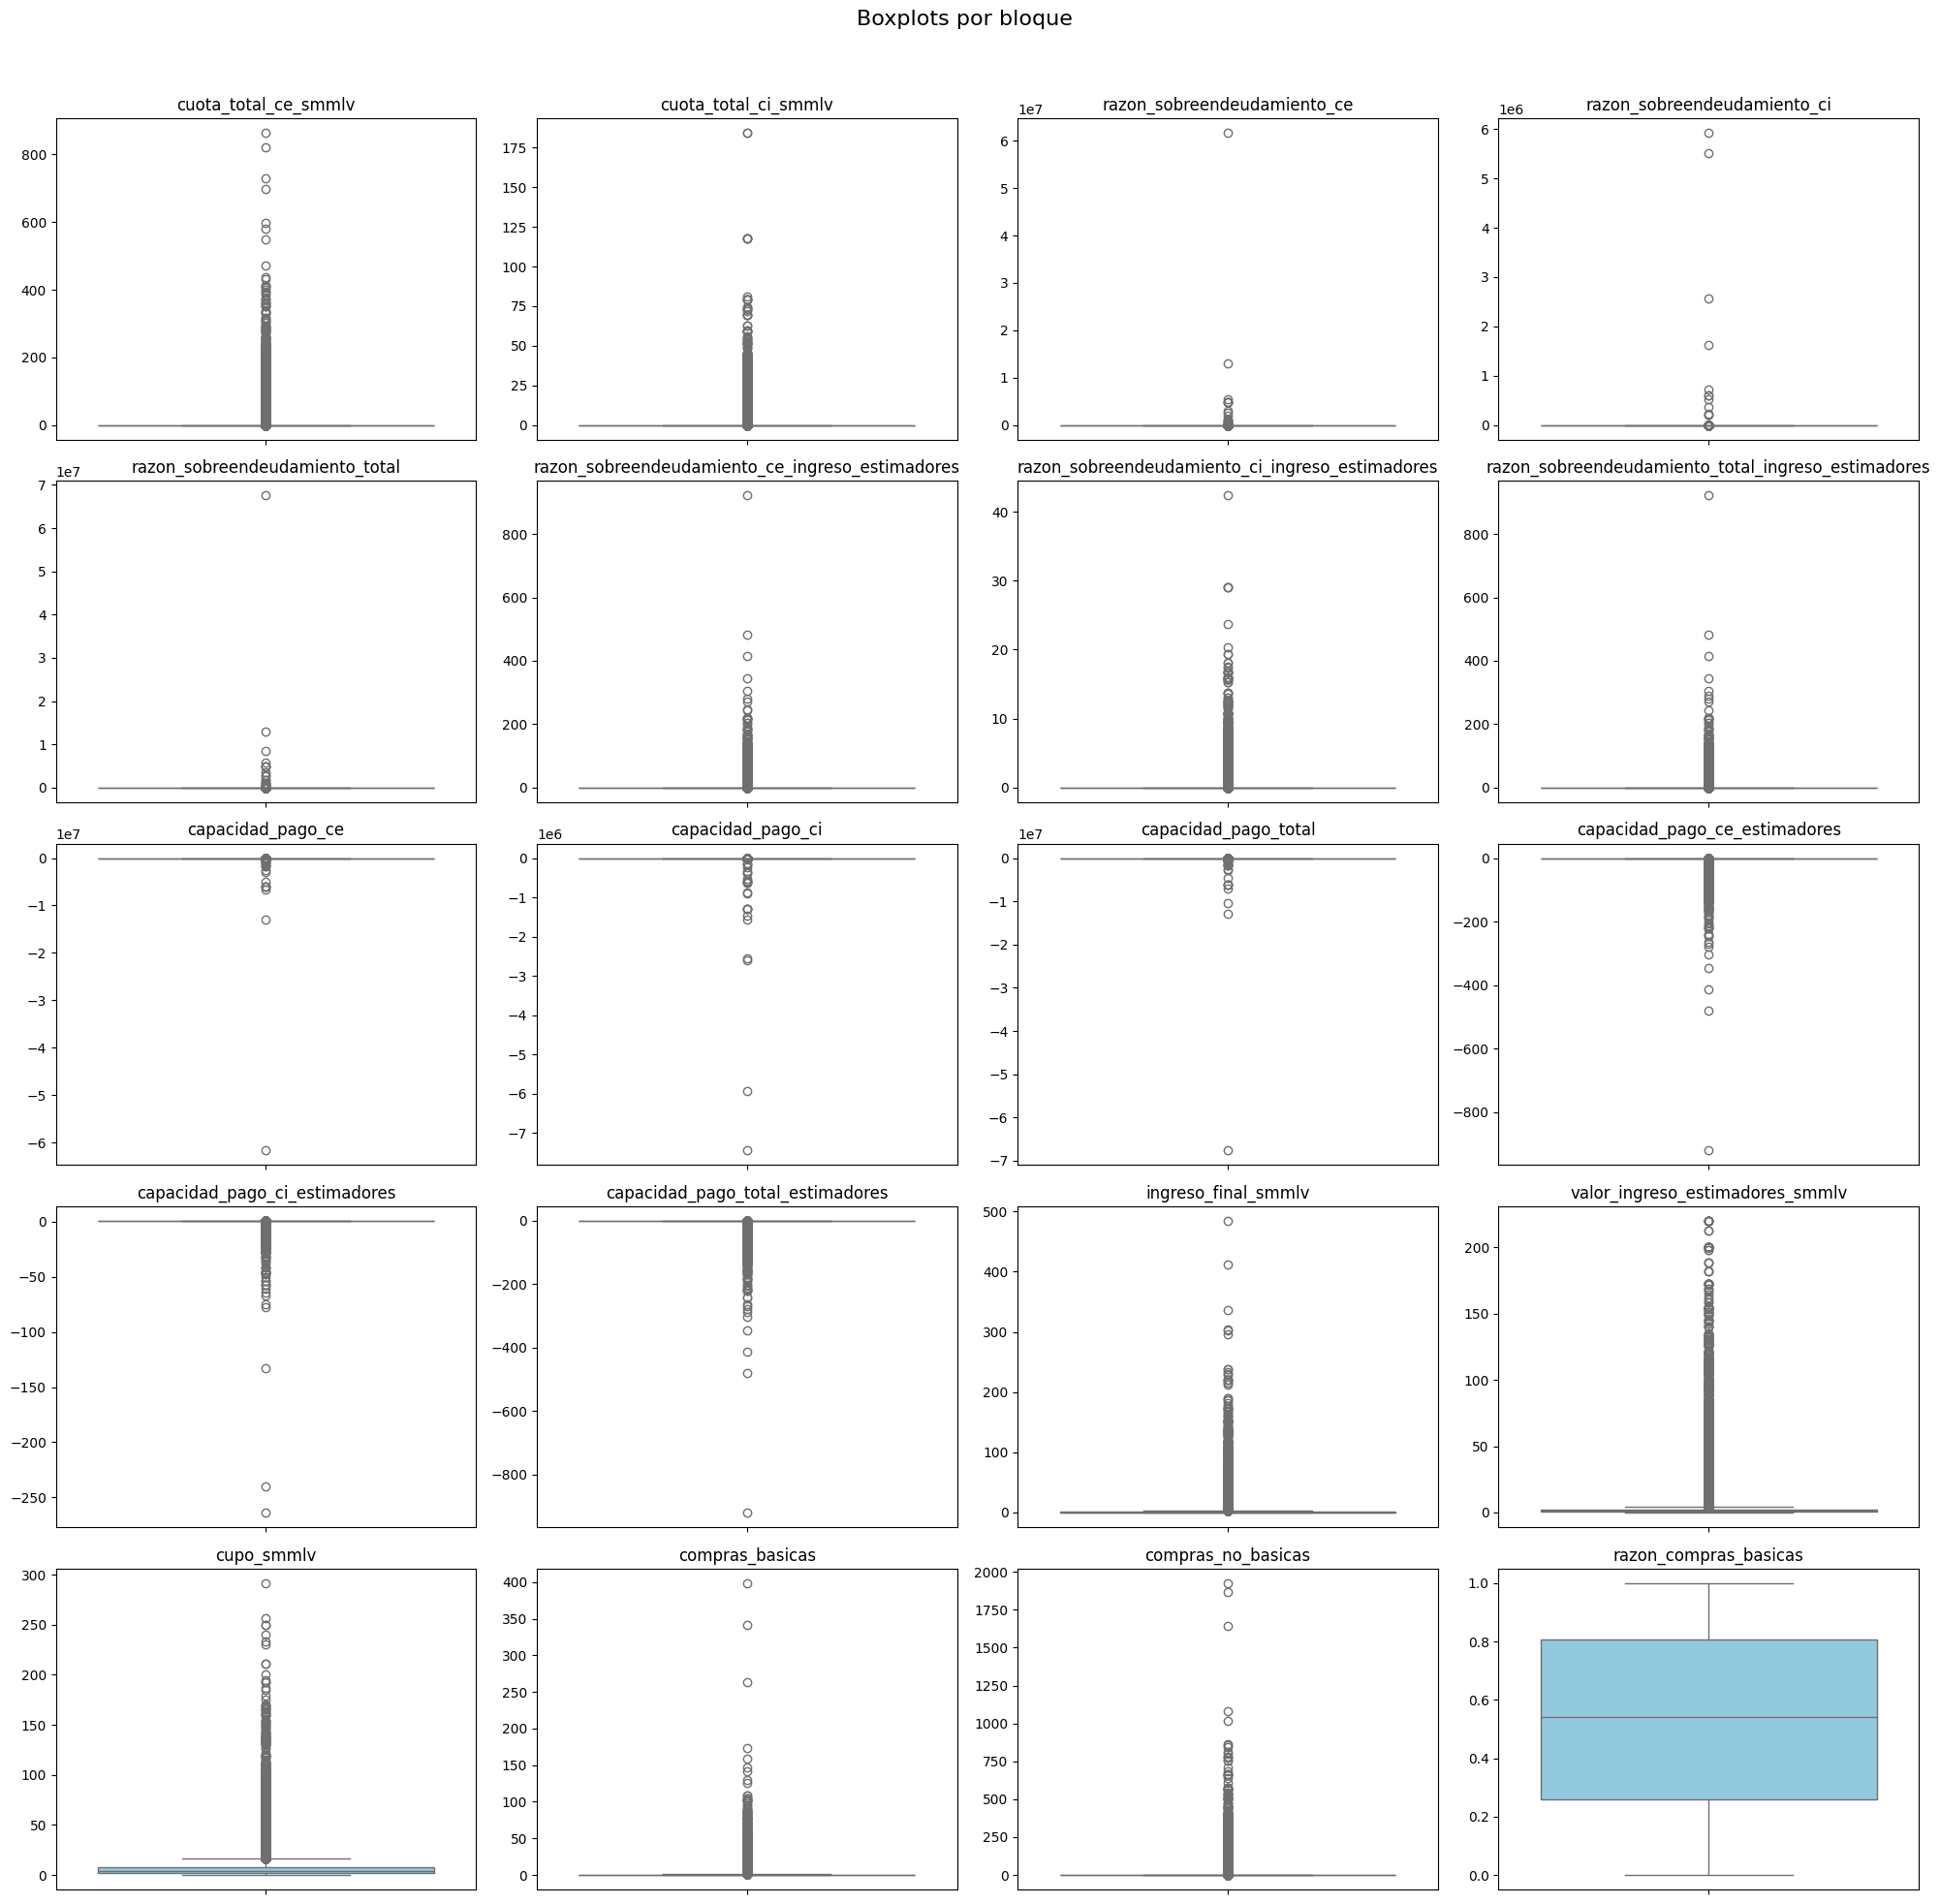

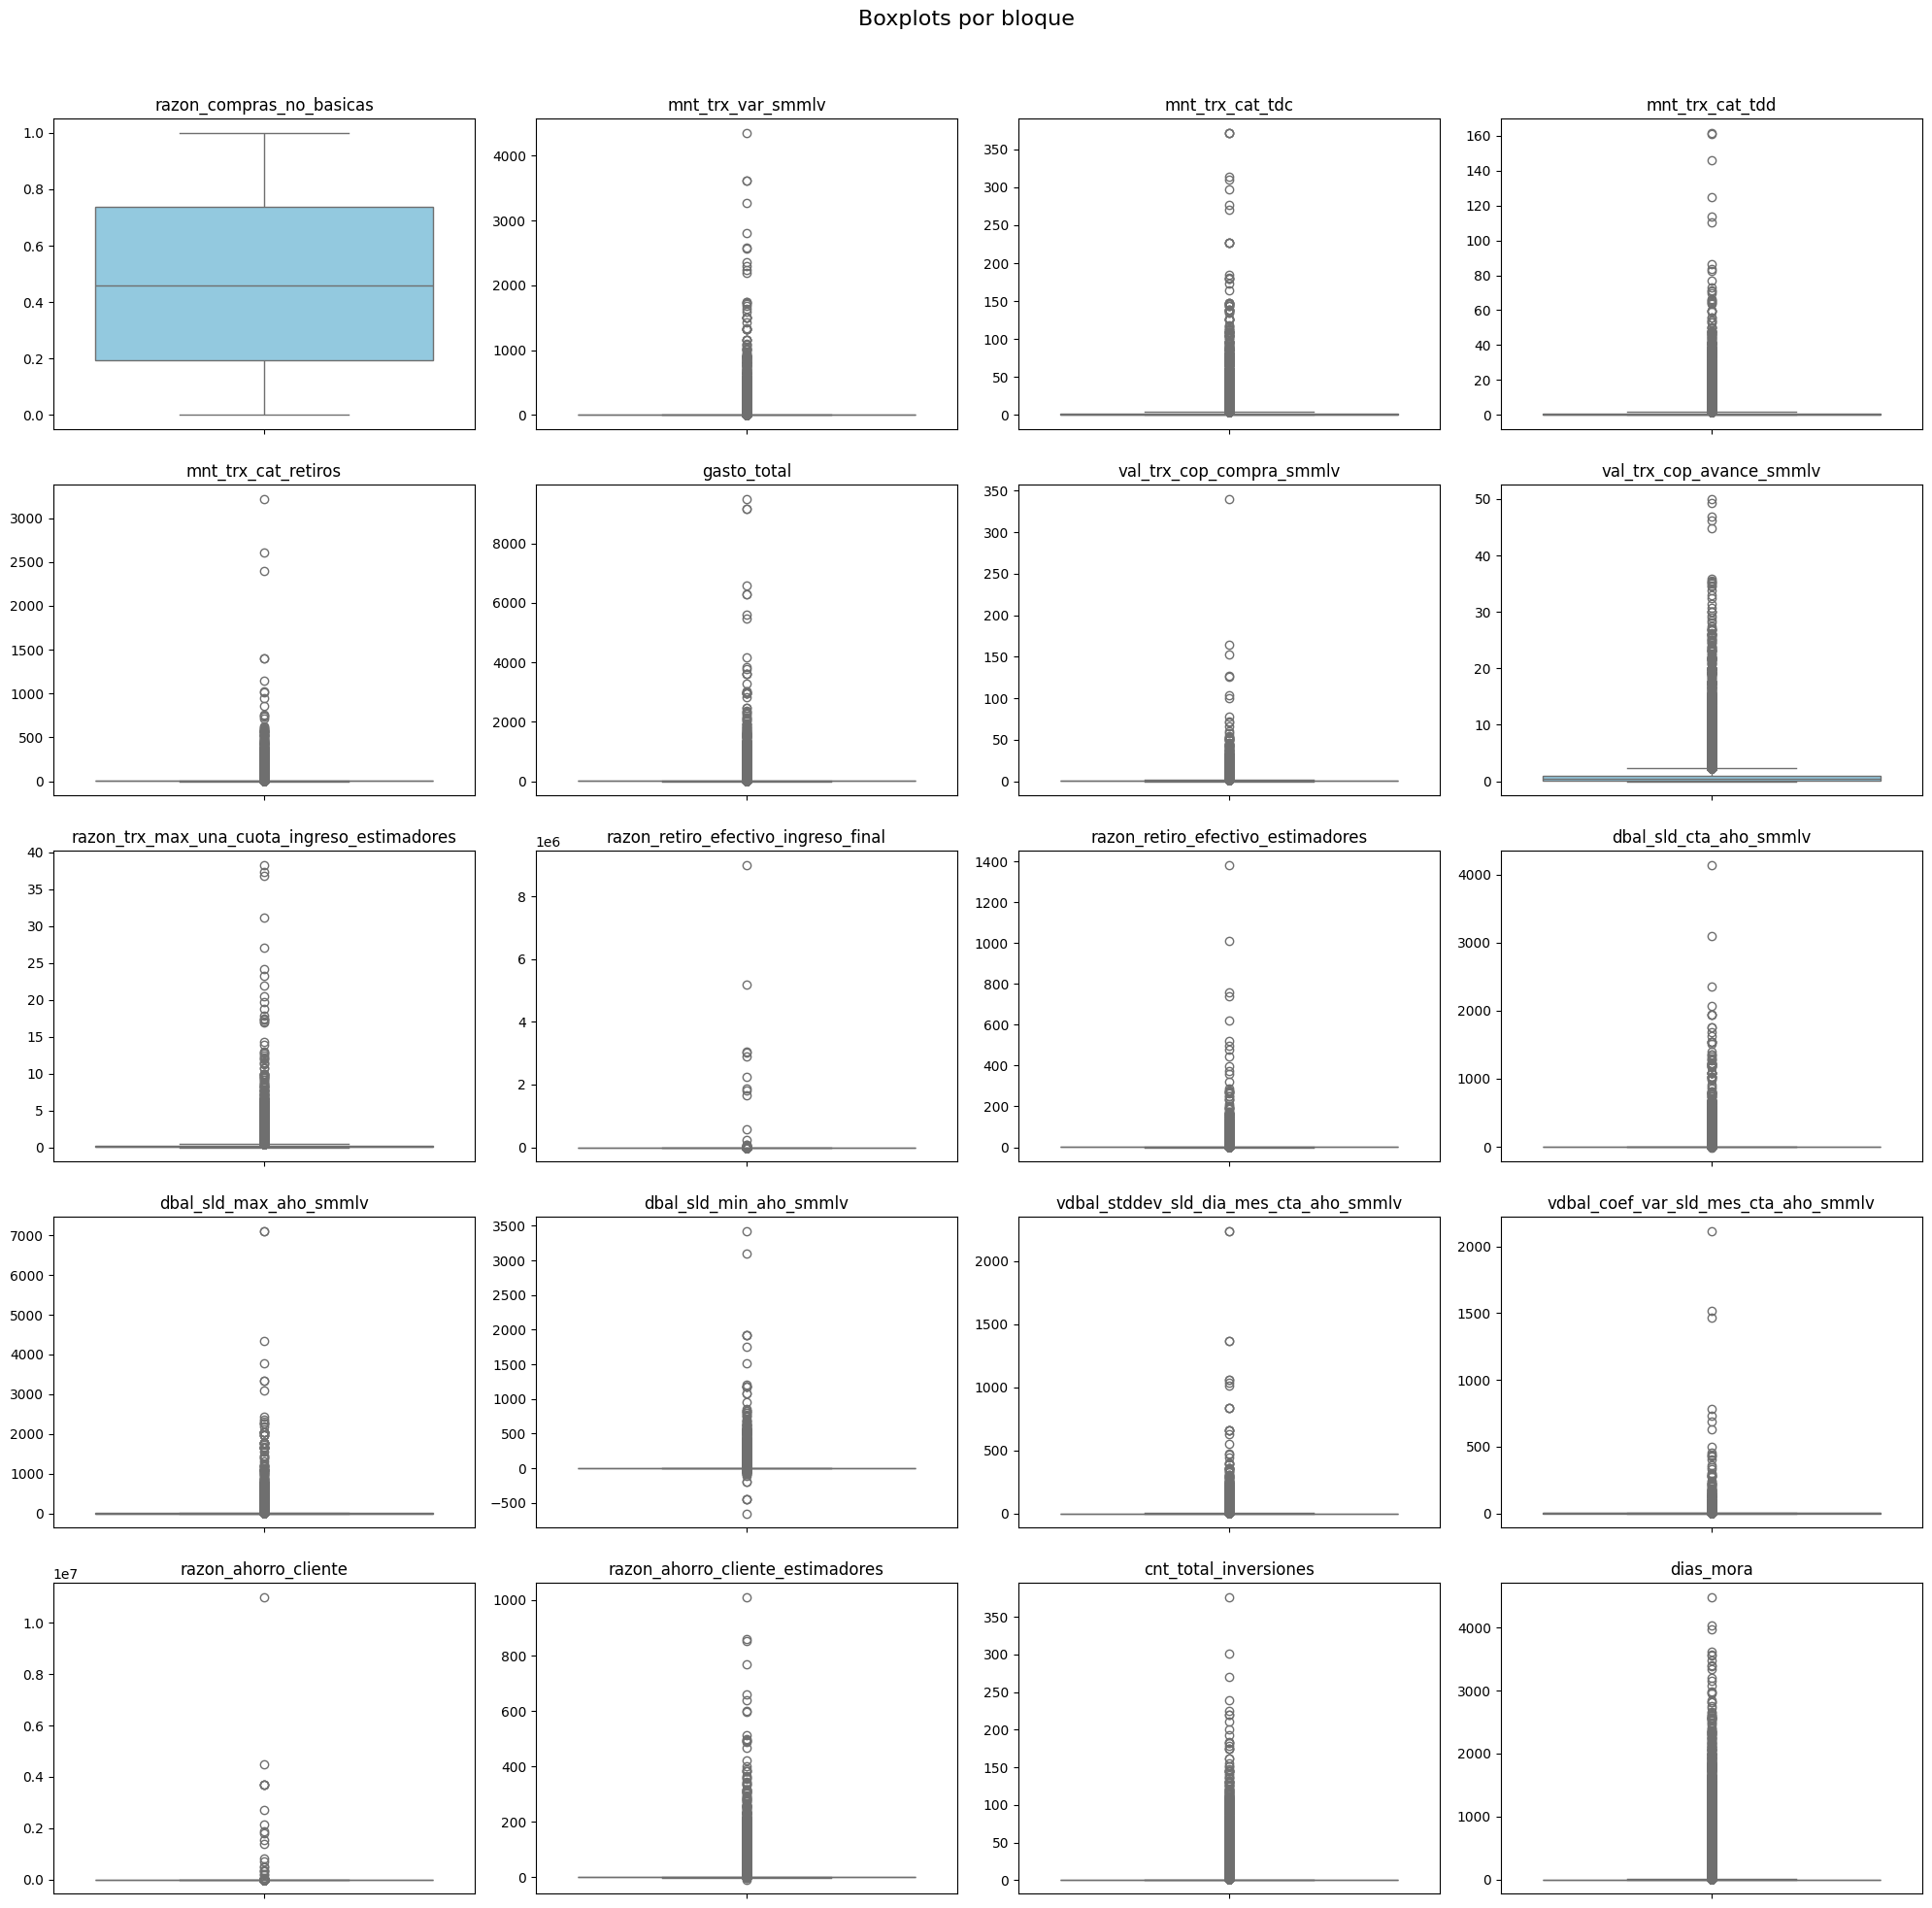

In [70]:
graficar_boxplots_por_bloques(
    df=df_final,
    columnas=columnas_numericas,
    n_cols=4,
    por_bloque=20
)

### Análisis de las gráficas Box-plots

A partir de los boxplots realizados, se puede observar una alta presencia de valores atípicos
(outliers) en prácticamente todas las variables analizadas.
Esto indica una fuerte dispersión en los datos y una distribución asimétrica en múltiples
dimensiones financieras, como la capacidad de pago, el endeudamiento, los ingresos
estimados y los hábitos de consumo. Específicamente, muchas variables presentan colas
largas hacia valores extremos, lo cual podría deberse a diferencias marcadas entre los
clientes en términos de ingresos, nivel de endeudamiento o acceso a productos financieros.
Por ejemplo, variables como `cuota_total_ci_smmlv`, `razon_sobreendeudamiento_total` o
`gasto_total` muestran algunos valores extremadamente altos, mientras que otras como
`capacidad_pago_total_estimadores` o `capacidad_pago_ce` revelan una gran concentración
de datos cercanos al valor mínimo, con pocos puntos muy elevados que distorsionan la
escala. En el caso de indicadores como `razon_compras_basicas` y
`razon_compras_no_basicas`, los datos están más contenidos entre 0 y 1, lo cual es
consistente con su naturaleza como proporciones. Estos gráficos sugieren una
fuerte heterogeneidad en la muestra, lo cual puede afectar el análisis estadístico si no se
controlan o transforman adecuadamente estos valores extremos. Este comportamiento
también pone de manifiesto la necesidad de normalizar o aplicar técnicas robustas en
etapas posteriores de modelado, con el fin de evitar que los valores atípicos dominen los
resultados.

### Correlaciones y gráficas bivariadas

En esta sección se analizan las relaciones entre variables mediante matrices de correlación y gráficas bivariadas. Estas visualizaciones permiten identificar dependencias lineales, redundancias entre variables numéricas y patrones de comportamiento respecto al target, facilitando la selección de variables y el diseño de estrategias de transformación para el modelamiento.

In [19]:
# Función para graficar matrices de correlacion
def graficar_matriz_correlacion(df: pd.DataFrame, metodo: str = "pearson", figsize=(18, 14)) -> None:
    """
    Grafica un heatmap con la matriz de correlación entre variables numéricas.

    Args:
        df (pd.DataFrame): DataFrame con las columnas numéricas.
        metodo (str): Método de correlación ('pearson', 'spearman', 'kendall').
        figsize (tuple): Tamaño de la figura.
    """
    # Filtrar solo variables numéricas
    df_numerico = df.select_dtypes(include=["float64", "int64"])

    # Calcular matriz de correlación
    correlacion = df_numerico.corr(method=metodo)

    # Graficar heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlacion, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                linewidths=0.5, cbar_kws={'label': f'Correlación ({metodo})'})
    plt.title(f"Matriz de Correlación ({metodo})", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Gráfica 5.

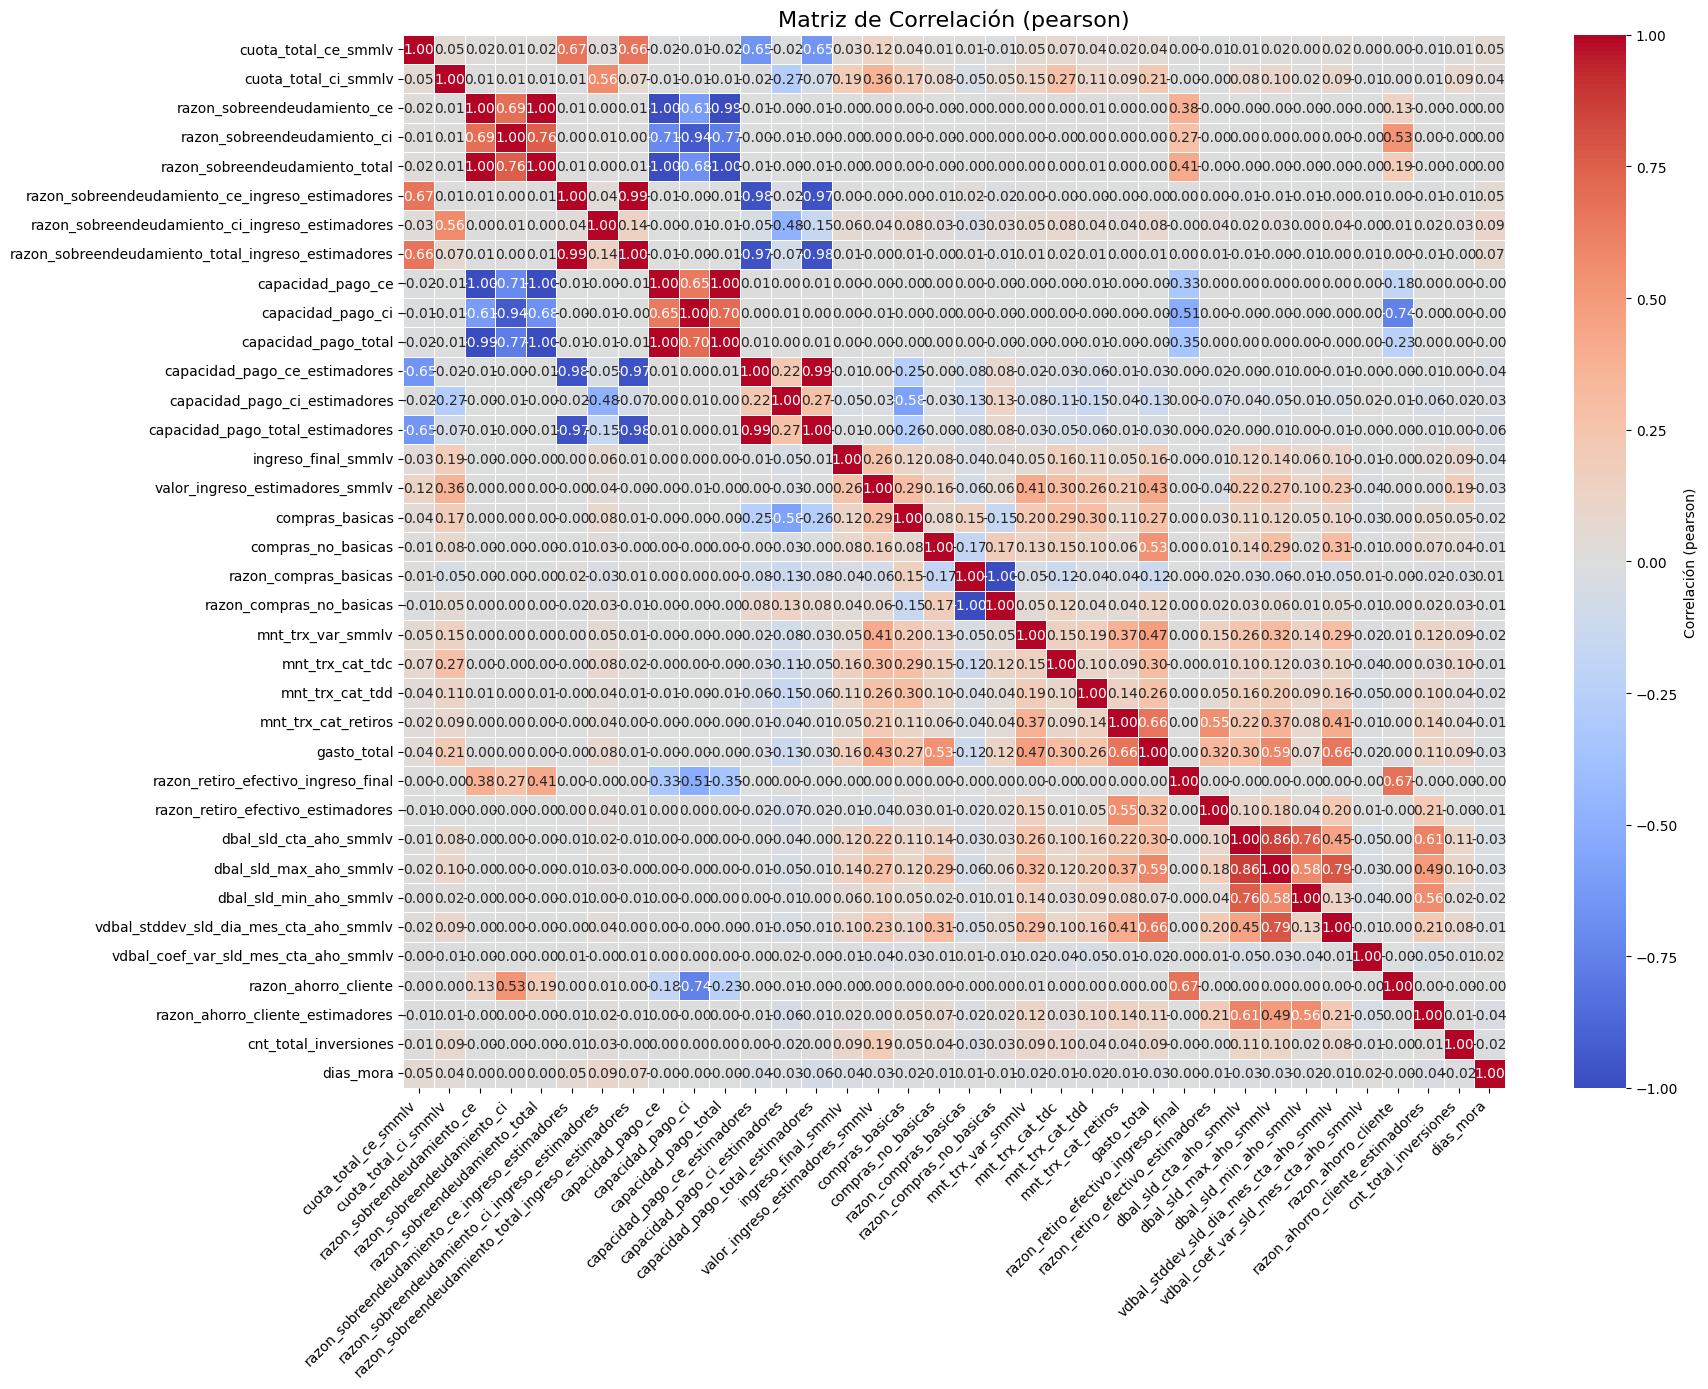

In [41]:
graficar_matriz_correlacion(df_final[columnas_numericas], metodo="pearson")

### Análisis y discusión

La matriz de correlación muestra relaciones claras y significativas entre varias variables
clave del análisis financiero. En primer lugar, las
variables relacionadas con la capacidad de pago (`capacidad_pago_ce`, `capacidad_pago_ci`,
`capacidad_pago_total` y sus estimadores) presentan correlaciones muy altas, cercanas o
superiores a 0.9, lo que confirma que estas métricas miden consistentemente el mismo
concepto de capacidad financiera para afrontar pagos. De manera similar, las razones de
sobreendeudamiento (`razon_sobreendeudamiento_ce`, ci y total) exhiben correlaciones
positivas muy fuertes, superiores a 0.75, mostrando una congruencia entre diferentes
indicadores de endeudamiento.
Las variables relacionadas con el saldo y ahorro en cuentas también presentan
correlaciones destacables; por ejemplo, el saldo máximo y promedio de ahorro
(`dbal_sld_max_aho_smmlv` y `dbal_sld_cta_aho_smmlv`) muestran una correlación superior
a 0.8, sugiriendo que los clientes que tienen altos saldos máximos suelen mantener
balances elevados de forma consistente. De igual forma, la desviación estándar del saldo y
el coeficiente de variación de saldo (`vdbal_stddev_sld_dia_mes_cta_aho_smmlv` y
`vdbal_coef_var_sld_mes_cta_aho_smmlv`) están correlacionados, indicando que la
volatilidad y variabilidad del saldo están relacionadas en el comportamiento del cliente.
Por otro lado, algunas variables demuestran poca o nula correlación con el resto, como
`dias_mora`, que presenta valores cercanos a cero en casi todas las correlaciones,
sugiriendo que los días de retraso en pagos no están directamente vinculados a la mayoría
de las otras variables financieras, lo que podría indicar un comportamiento independiente o
influenciado por factores externos no considerados en este dataset.
En cuanto a variables de gasto y consumo, `gasto_total` se correlaciona positivamente con
`mnt_trx_cat_retiros` y `mnt_trx_var_smmlv`, con coeficientes alrededor de 0.5, mostrando que
mayores retiros y transacciones variables están relacionados con un mayor gasto total.
Asimismo, las variables de `compras_basicas` y
`compras_no_basicas` tienen correlaciones positivas moderadas con
`valor_ingreso_estimadores_smmlv`, lo que indica que el nivel de ingreso estimado influye en
el patrón de consumo.
Finalmente, se observa una fuerte correlación entre algunas razones financieras específicas
y sus estimadores, como la relación entre `dbal_sld_cta_aho_smmlv` y
`razon_ahorro_cliente_estimadores`, con valores cercanos a 0.6, lo que reafirma la validez de
las estimaciones usadas en el análisis.
En resumen, la matriz destaca agrupamientos claros de variables que representan
conceptos financieros similares, evidencia la robustez de ciertos indicadores y resalta
variables independientes que podrían ser analizadas con más detalle para entender su
comportamiento único dentro del contexto del análisis financiero.


In [19]:
# Función para Grafica bivaridada respecto al target
def boxplot_vs_target(df, variable_num, target='valor_g'):
    # Eliminar filas con nulos en variable o target
    df_plot = df[[variable_num, target]].dropna()
    
    # Ordenar categorías excluyendo nulos
    orden = sorted([g for g in df_plot[target].unique()])
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=target, y=variable_num, data=df_plot, order=orden)
    plt.title(f"{variable_num} por grupo de riesgo ({target})")
    plt.xlabel("Grupo de riesgo")
    plt.ylabel(variable_num)
    plt.tight_layout()
    plt.show()


## Gráfica 6.

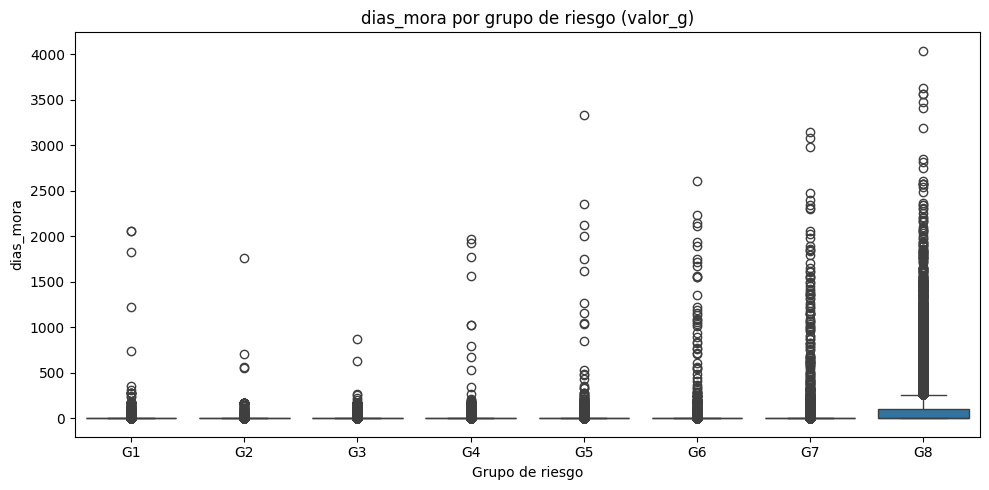

In [46]:
boxplot_vs_target(df_final, "dias_mora")

In [20]:
def histograma_vs_target(df, variable_num, target='valor_g', bins=50):
    df_plot = df[[variable_num, target]].dropna()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df_plot,
        x=variable_num,
        hue=target,
        bins=bins,
        multiple='stack',  # puedes cambiar a 'dodge' o 'fill' según prefieras
        palette='Set1'
    )
    plt.title(f"Distribución de {variable_num} por grupo de riesgo ({target})")
    plt.xlabel(variable_num)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


## Gráfica 7.

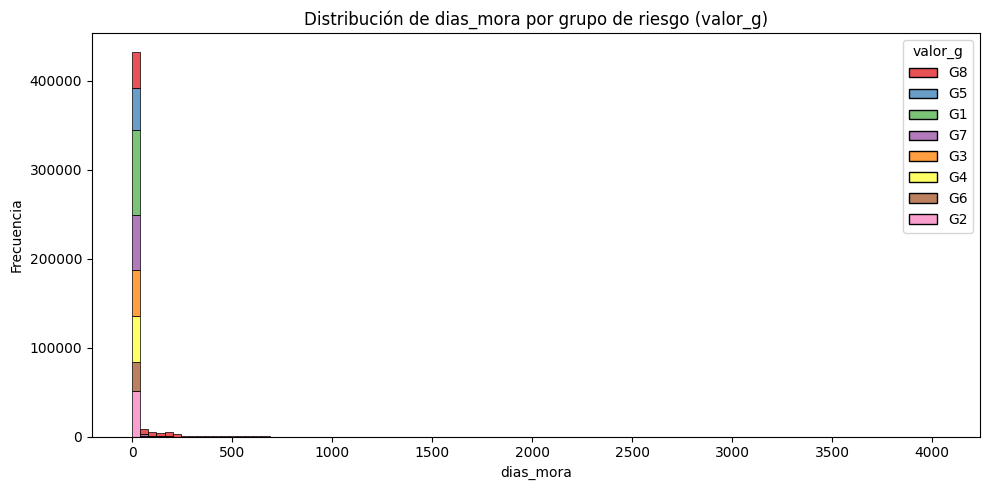

In [50]:
histograma_vs_target(df_final, "dias_mora", bins=100)

In [21]:
def grafico_dicotomica_vs_target(df, variable_binaria, target='valor_g', modo='proporcion'):
    """
    Grafica una variable binaria contra una variable categórica (como valor_g).
    Puedes ver conteos absolutos o proporciones.
    
    Args:
        df: DataFrame
        variable_binaria: str - columna 0/1
        target: str - columna categórica
        modo: 'conteo' o 'proporcion'
    """
    df_plot = df[[variable_binaria, target]].dropna()

    if modo == 'proporcion':
        # Calcular proporción de 1s por grupo
        prop = df_plot.groupby(target)[variable_binaria].mean().reset_index()
        sns.barplot(data=prop, x=target, y=variable_binaria, order=sorted(prop[target]))
        plt.ylabel(f"Proporción de {variable_binaria} = 1")
    else:
        # Conteo de 0s y 1s por grupo
        crosstab = pd.crosstab(df_plot[target], df_plot[variable_binaria], normalize='index')
        crosstab = crosstab[[1]] if 1 in crosstab.columns else crosstab  # por si no hay ningún 1
        crosstab.columns = [f"{variable_binaria} = 1"]
        crosstab.reset_index(inplace=True)
        sns.barplot(data=crosstab, x=target, y=f"{variable_binaria} = 1", order=sorted(crosstab[target]))
        plt.ylabel(f"Proporción de {variable_binaria} = 1")
    
    plt.xlabel(target)
    plt.title(f"{variable_binaria} respecto a {target}")
    plt.tight_layout()
    plt.show()


## Gráfica 8.

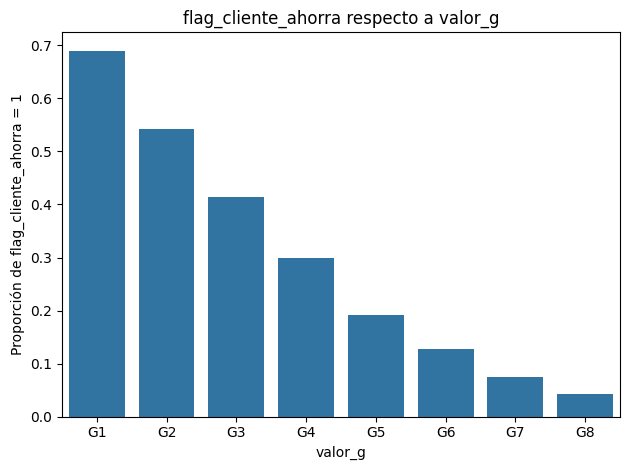

In [52]:
grafico_dicotomica_vs_target(df_final, "flag_cliente_ahorra")

## Gráfica 9.

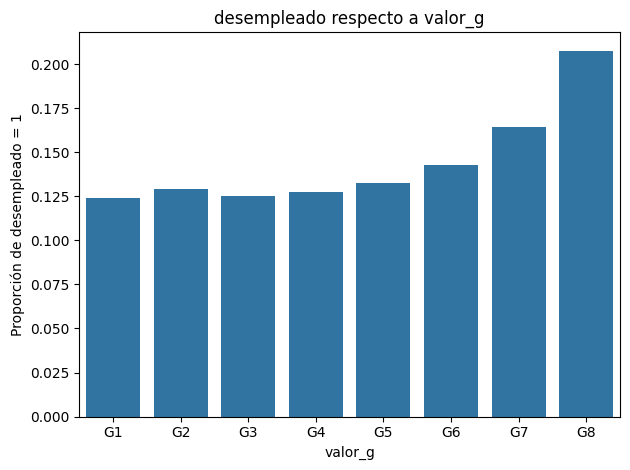

In [53]:
grafico_dicotomica_vs_target(df_final, "desempleado")

## Gráfica 10.

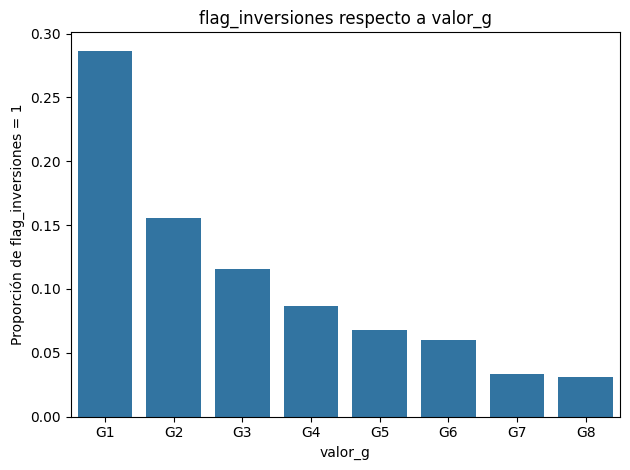

In [54]:
grafico_dicotomica_vs_target(df_final, "flag_inversiones")

### Análisis de las gráficas bivariadas

El análisis multivariado de las gráficas revela una clara relación entre el nivel de riesgo
crediticio y el comportamiento financiero de los clientes. A
medida que aumenta el nivel de riesgo (de G1 a G8), se observa un incremento significativo
en los días de mora, tanto en términos de dispersión como de valores extremos,
especialmente en G8. Paralelamente, la proporción de clientes con hábitos financieros
positivos, como el ahorro y las inversiones, disminuye de forma consistente conforme se
eleva el riesgo, siendo G1 el grupo con mayor propensión a ahorrar e invertir y G8 el de
menor. Asimismo, la tasa de desempleo muestra una tendencia ascendente con el nivel de
riesgo, alcanzando su punto máximo en G8. Estos patrones reflejan que los clientes con
menor riesgo (G1-G3) presentan comportamientos financieros más saludables y mayor
estabilidad laboral, mientras que los de mayor riesgo (G6-G8) están más expuestos a
incumplimientos, tienen menor participación en productos financieros y presentan mayores
tasas de desempleo, lo que valida la segmentación del banco como una herramienta útil
para la gestión y predicción del riesgo crediticio.


# Preparación de los Datos

In [22]:
df_final_procesado = df_final.drop(columns=columnas_no_utilizadas)

In [23]:
df_final_procesado.shape

(1598523, 80)

### Nulidad

In [24]:
def grafico_nulos(df: pd.DataFrame, top_n: int = None):
    """
    Grafica el porcentaje de valores nulos por columna en un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame a analizar.
        top_n (int, opcional): Número máximo de columnas a mostrar (las con mayor % de nulos).
    """
    null_percent = df.isnull().mean().sort_values(ascending=False) * 100
    null_percent = null_percent[null_percent > 0]

    if top_n:
        null_percent = null_percent.head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=null_percent.values, y=null_percent.index, hue=null_percent.index, palette="viridis")
    plt.xlabel("Porcentaje de valores nulos")
    plt.ylabel("Variables")
    plt.title("Porcentaje de nulidad por columna")
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

    return null_percent

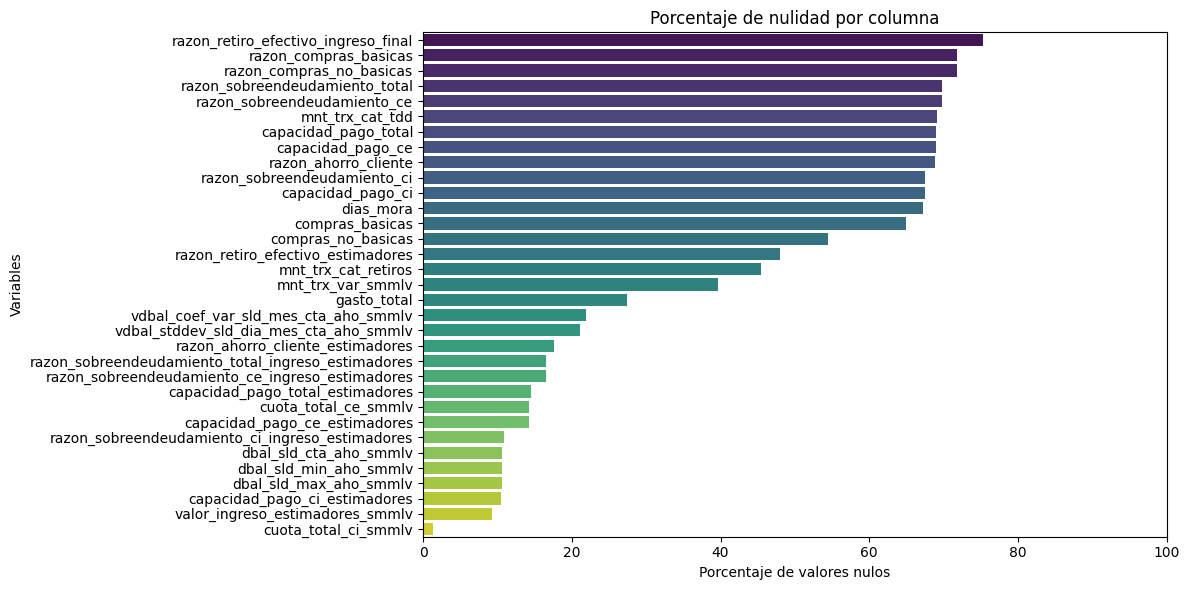

In [82]:
# Nulidad para columnas numericas
porcentaje_nulos = grafico_nulos(df_final_procesado[columnas_numericas])

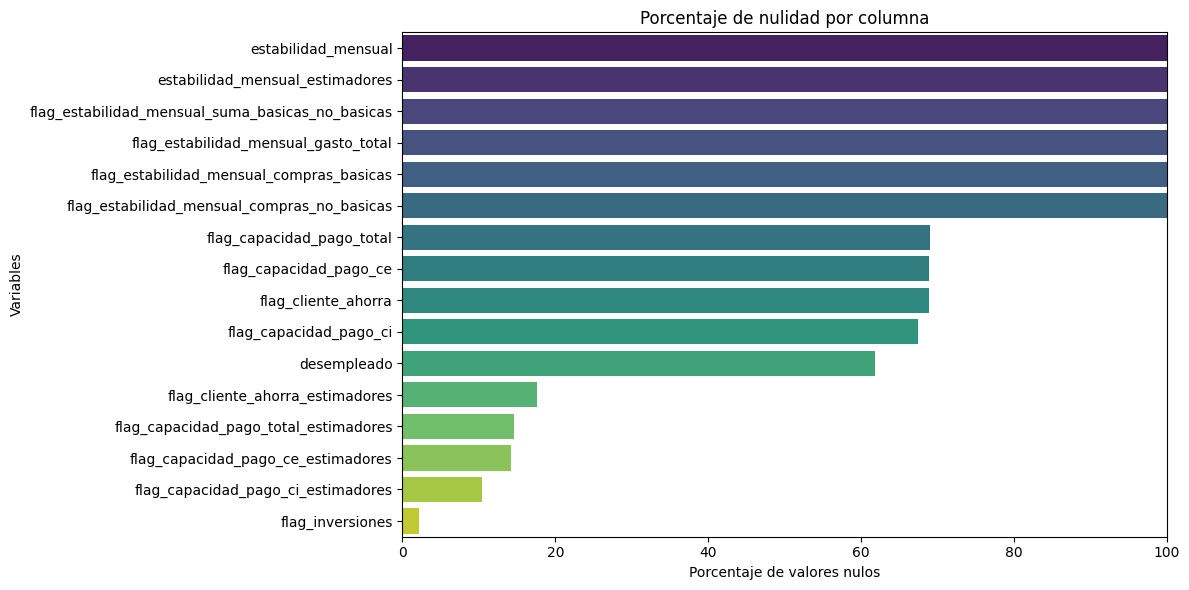

In [84]:
# Nulidad para columnas dicotomicas
porcentaje_nulos = grafico_nulos(df_final_procesado[columnas_dicotomicas])

In [25]:
# Calcular proporción de nulos por columna
nulos = df_final_procesado.isnull().mean()

# Seleccionar columnas con más del 80% de nulos
cols_a_eliminar = nulos[nulos > 0.80].index.tolist()

# # Eliminar del DataFrame
df_final_procesado = df_final_procesado.drop(columns=cols_a_eliminar)

# Mostrar resumen
print(f"Se eliminaron {len(cols_a_eliminar)} columnas con más del 80% de nulidad.")

Se eliminaron 12 columnas con más del 80% de nulidad.


In [26]:
cols_a_eliminar

['cnt_total_inversiones',
 'mnt_trx_cat_tdc',
 'estabilidad_mensual',
 'estabilidad_mensual_estimadores',
 'flag_estabilidad_mensual_compras_basicas',
 'flag_estabilidad_mensual_compras_no_basicas',
 'flag_estabilidad_mensual_suma_basicas_no_basicas',
 'flag_estabilidad_mensual_gasto_total',
 'cupo_smmlv',
 'val_trx_cop_compra_smmlv',
 'val_trx_cop_avance_smmlv',
 'razon_trx_max_una_cuota_ingreso_estimadores']

## Duplicidad

In [27]:
# Contar filas duplicadas
duplicados = df_final_procesado.duplicated()

# Ver cuántos hay
print(f"Total de filas duplicadas: {duplicados.sum()}")

Total de filas duplicadas: 62599


In [28]:
df_duplicadas = df_final_procesado[df_final_procesado.duplicated()]
df_duplicadas.head()

,fecha_orden,year,month,tipo_doc,cod_estado_cli,num_doc,cod_segm,dias_mora,desempleado,ingreso_final_smmlv,...,razon_retiro_efectivo_estimadores,flag_estabilidad_6m_compras_basicas,flag_estabilidad_6m_compras_no_basicas,flag_estabilidad_6m_suma_basicas_no_basicas,flag_estabilidad_6m_asto_total,flag_retiro_efectivo_bajo_ingreso_final,flag_retiro_efectivo_bajo_estimadores,flag_avances_cupo_uso_tdc,flag_mal_uso_tdc_trx_max_ingreso_estimadores,valor_g
12,202310,2023,10,1,1,82ecb1604c,6,0.0,0.0,12.895690,...,NaN,1,1,1,1,0,0,0,0,G1
40,202103,2021,3,1,1,98f8e666de,4,0.0,NaN,0.000000,...,0.879531,1,1,1,1,0,0,0,0,G1
50,202206,2022,6,2,1,26ad16738e,6,0.0,0.0,30.207800,...,0.204046,1,1,1,1,1,1,0,0,G1
51,202206,2022,6,2,1,26ad16738e,6,0.0,0.0,30.207800,...,0.204046,1,1,1,1,1,1,0,0,G1
122,202207,2022,7,1,1,09ad3835b4,M,0.0,0.0,1.679448,...,NaN,1,1,1,1,0,0,0,0,G1


In [29]:
df_final_procesado.shape

(1598523, 68)

In [30]:
df_final_procesado = df_final_procesado.drop_duplicates()

In [31]:
df_final_procesado.shape

(1535924, 68)

In [32]:
# 3.9 % de datos duplicados eliminados
(62599 / 1598523) * 100

3.916052505969573

## Valores atipicos

In [33]:
def graficar_outliers_vs_nulos(df: pd.DataFrame, cols_numericas: list, top_n: int = None):
    """
    Grafica por cada variable numérica el número de outliers y registros no nulos.

    Args:
        df (pd.DataFrame): DataFrame con las variables numéricas.
        top_n (int): Número máximo de columnas a mostrar (ordenadas por % de outliers).
    """
    outliers = {}
    non_nulls = {}

    for col in cols_numericas:
        serie = pd.to_numeric(df[col], errors='coerce').dropna()
        q1 = serie.quantile(0.25)
        q3 = serie.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers[col] = ((serie < lower) | (serie > upper)).sum()
        non_nulls[col] = serie.count()

    df_plot = pd.DataFrame({
        "outliers": pd.Series(outliers),
        "non_nulls": pd.Series(non_nulls)
    })

    # Porcentaje de outliers
    df_plot["pct_outliers"] = df_plot["outliers"] / df_plot["non_nulls"]
    df_plot = df_plot.sort_values("pct_outliers", ascending=False)

    if top_n:
        df_plot = df_plot.head(top_n)

    # Gráfico
    plt.figure(figsize=(14, 6))
    sns.barplot(x=df_plot.index, y="non_nulls", data=df_plot, color="lightgray", label="No nulos")
    sns.barplot(x=df_plot.index, y="outliers", data=df_plot, color="crimson", label="Outliers")

    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Conteo")
    plt.title("Outliers vs Registros No Nulos por Variable Numérica")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_plot


In [34]:
columnas_numericas = list(set(columnas_numericas) - set(cols_a_eliminar))

In [35]:
len(columnas_numericas)

34

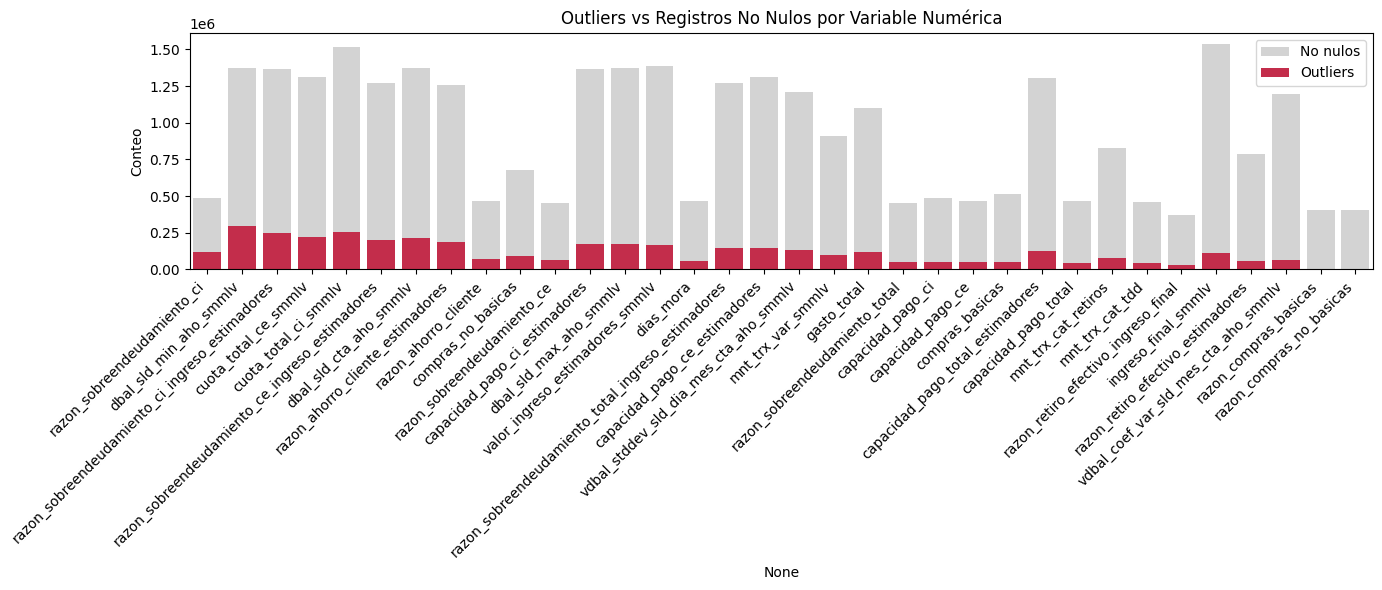

In [103]:
resultado = graficar_outliers_vs_nulos(df_final_procesado, columnas_numericas)

In [36]:
def eliminar_outliers_iqr(df: pd.DataFrame, columnas: list) -> pd.DataFrame:
    """
    Elimina filas con valores atípicos (outliers) según IQR en las columnas especificadas.

    Args:
        df (pd.DataFrame): DataFrame original.
        columnas (list): Lista de columnas numéricas donde eliminar outliers.

    Returns:
        pd.DataFrame: DataFrame sin los outliers.
    """
    df_filtrado = df.copy()
    for col in columnas:
        if pd.api.types.is_numeric_dtype(df_filtrado[col]):
            serie = pd.to_numeric(df_filtrado[col], errors='coerce')
            q1 = serie.quantile(0.25)
            q3 = serie.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            # Eliminar filas donde el valor sea un outlier
            df_filtrado = df_filtrado[(serie >= lower) & (serie <= upper)]

    return df_filtrado


In [37]:
df_final_sin_outliers = eliminar_outliers_iqr(df_final_procesado, columnas_numericas)

print(f"Filas originales: {len(df_final_procesado)}")
print(f"Filas después de eliminar outliers: {len(df_final_sin_outliers)}")

Filas originales: 1535924
Filas después de eliminar outliers: 5116


In [38]:
def reemplazar_outliers_por_nan(df: pd.DataFrame, columnas: list) -> pd.DataFrame:
    """
    Reemplaza los outliers por NaN en lugar de eliminar filas completas.

    Args:
        df (pd.DataFrame): DataFrame original.
        columnas (list): Lista de columnas numéricas a tratar.

    Returns:
        pd.DataFrame: DataFrame con outliers reemplazados por NaN.
    """
    df_filtrado = df.copy()
    for col in columnas:
        if pd.api.types.is_numeric_dtype(df_filtrado[col]):
            serie = pd.to_numeric(df_filtrado[col], errors='coerce')
            q1 = serie.quantile(0.25)
            q3 = serie.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            # Reemplazar outliers por NaN
            df_filtrado[col] = serie.where((serie >= lower) & (serie <= upper), np.nan)

    return df_filtrado


In [39]:
df_outliers_nan = reemplazar_outliers_por_nan(df_final_procesado, columnas_numericas)

# Ver porcentaje de nulos después
null_pct_post = df_outliers_nan.isnull().mean().sort_values(ascending=False)
print(null_pct_post.head(10))

razon_retiro_efectivo_ingreso_final    0.777755
razon_sobreendeudamiento_ci            0.758734
razon_sobreendeudamiento_ce            0.744741
razon_ahorro_cliente                   0.739242
razon_sobreendeudamiento_total         0.735921
razon_compras_no_basicas               0.734257
razon_compras_basicas                  0.734257
dias_mora                              0.733090
mnt_trx_cat_tdd                        0.728863
capacidad_pago_ce                      0.727450
dtype: float64


In [40]:
df_outliers_nan.shape

(1535924, 68)

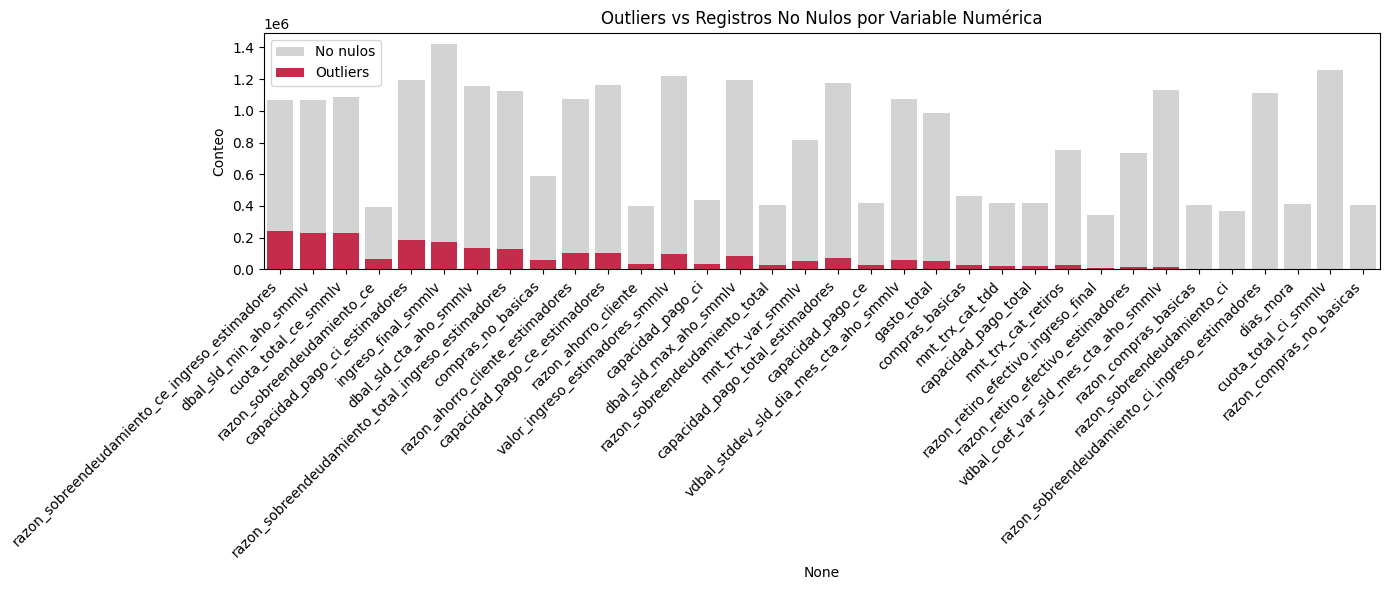

In [110]:
resultado2 = graficar_outliers_vs_nulos(df_outliers_nan, columnas_numericas)

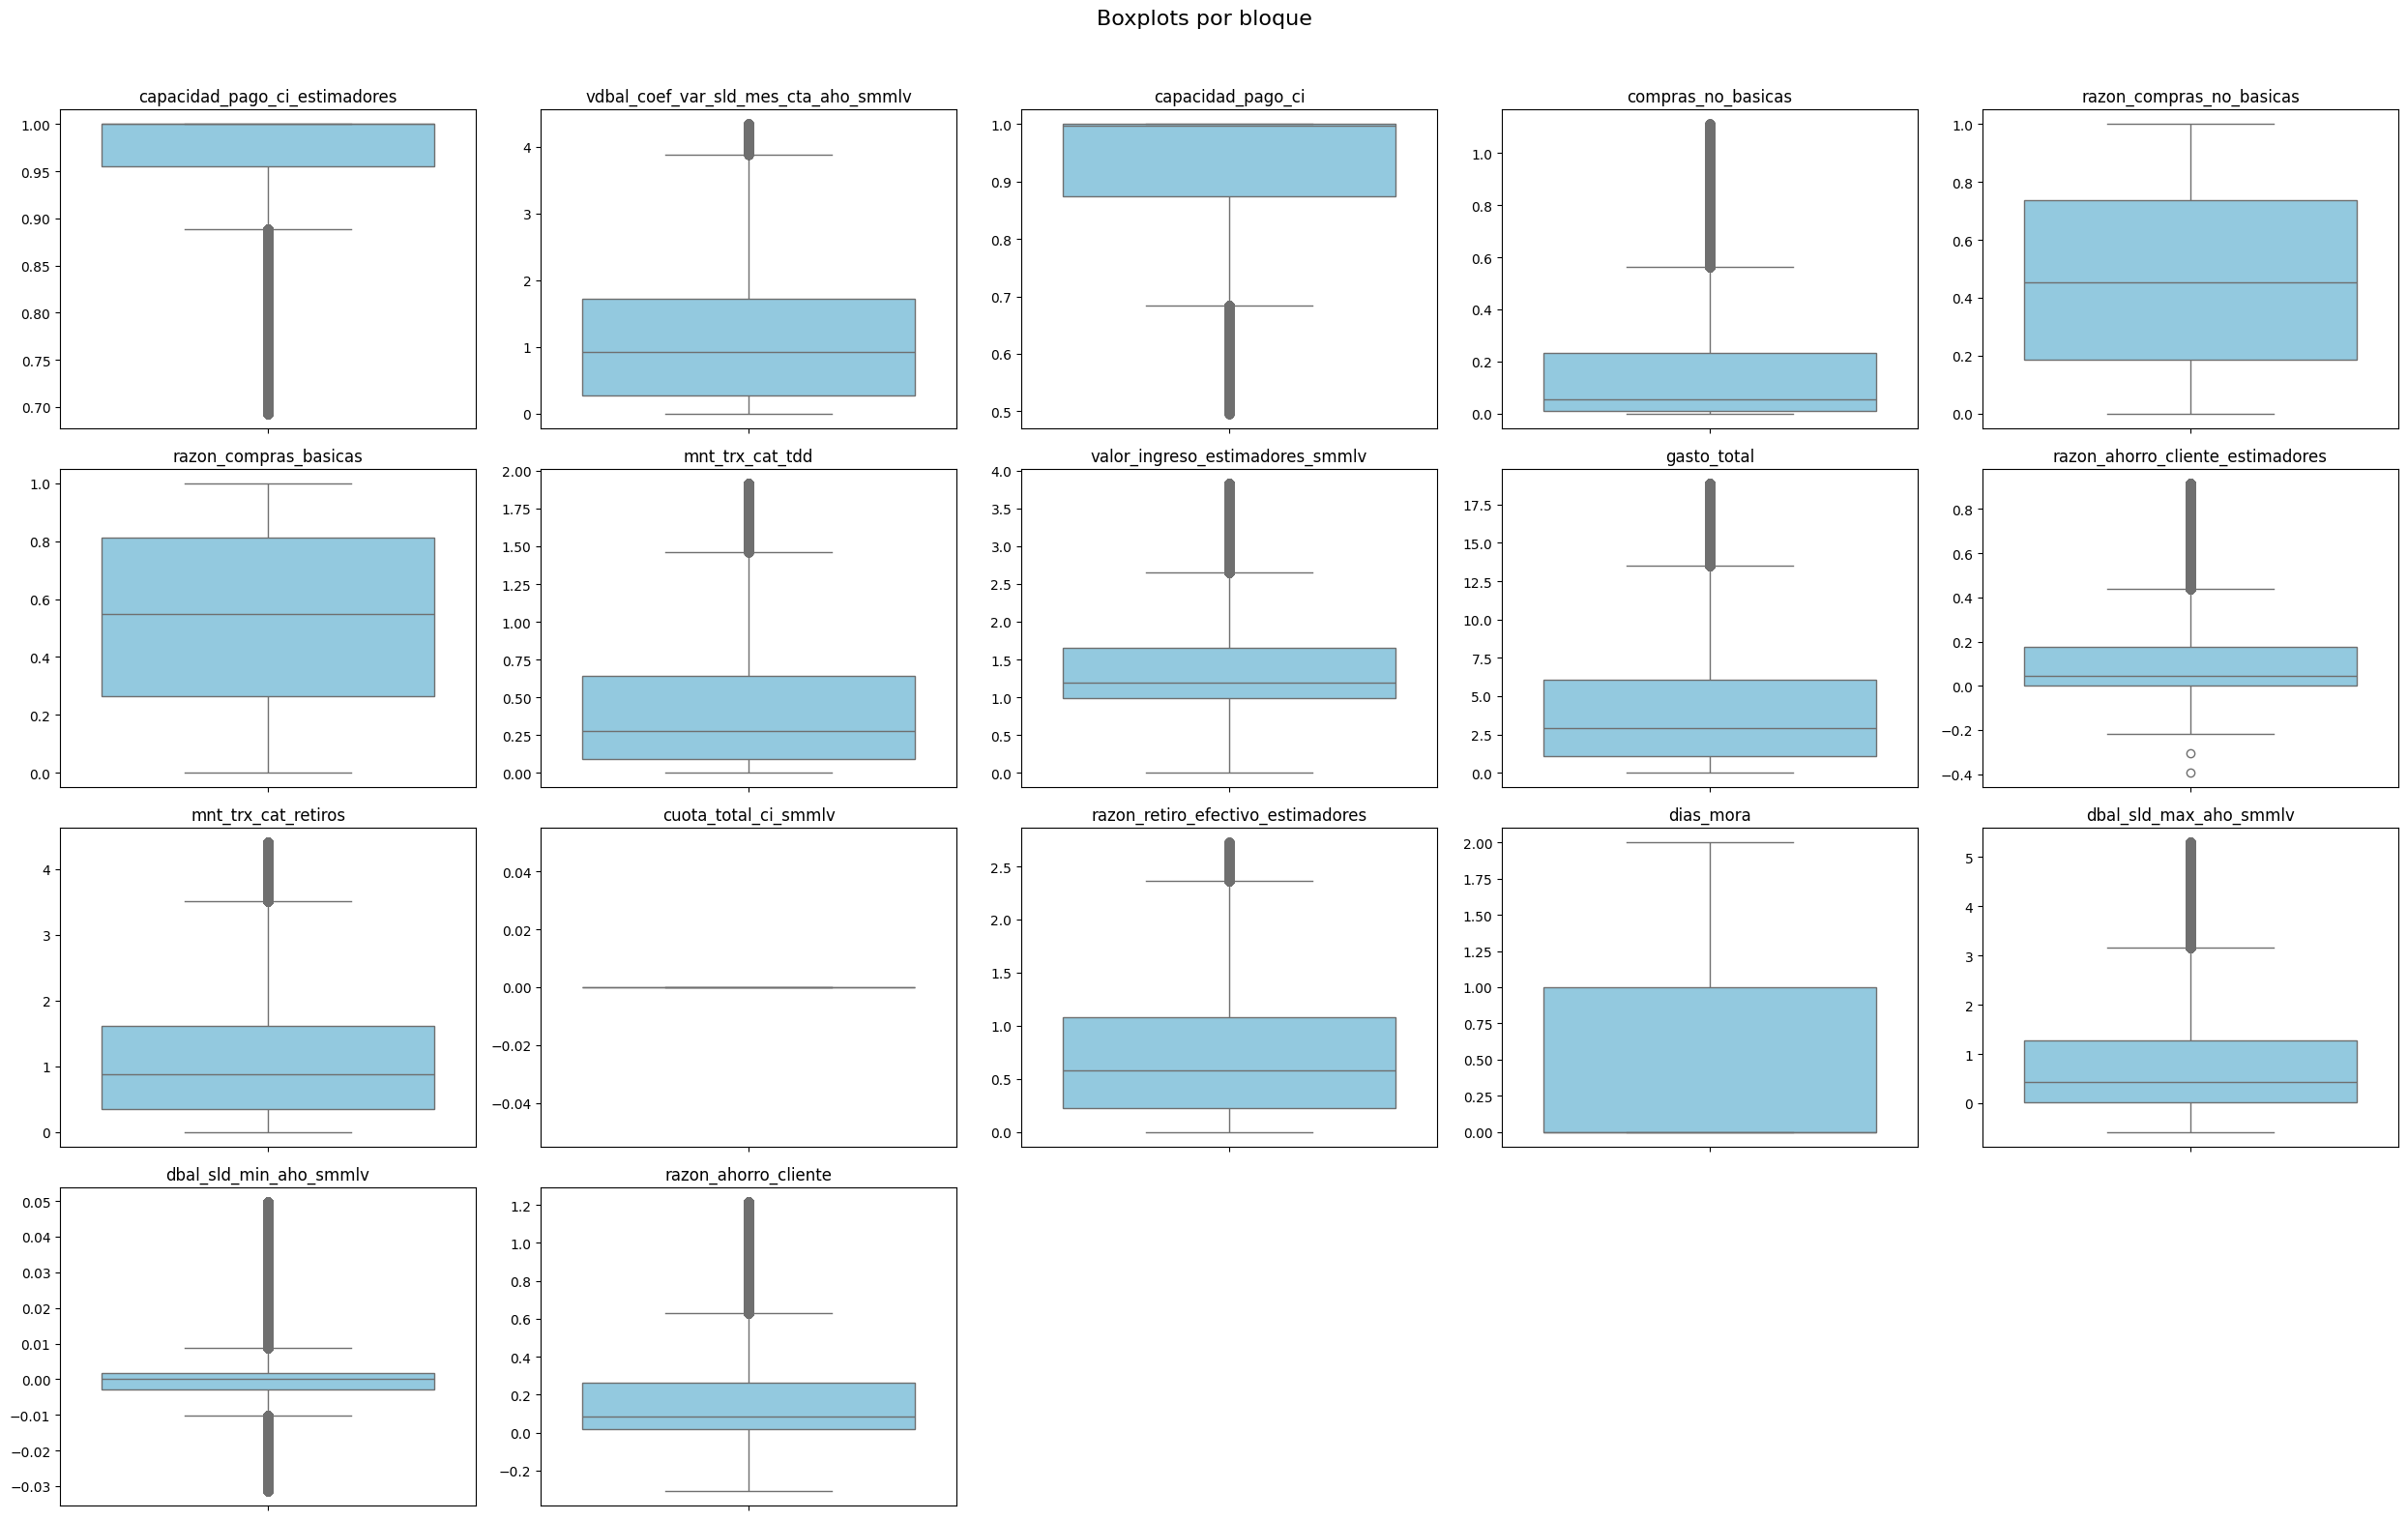

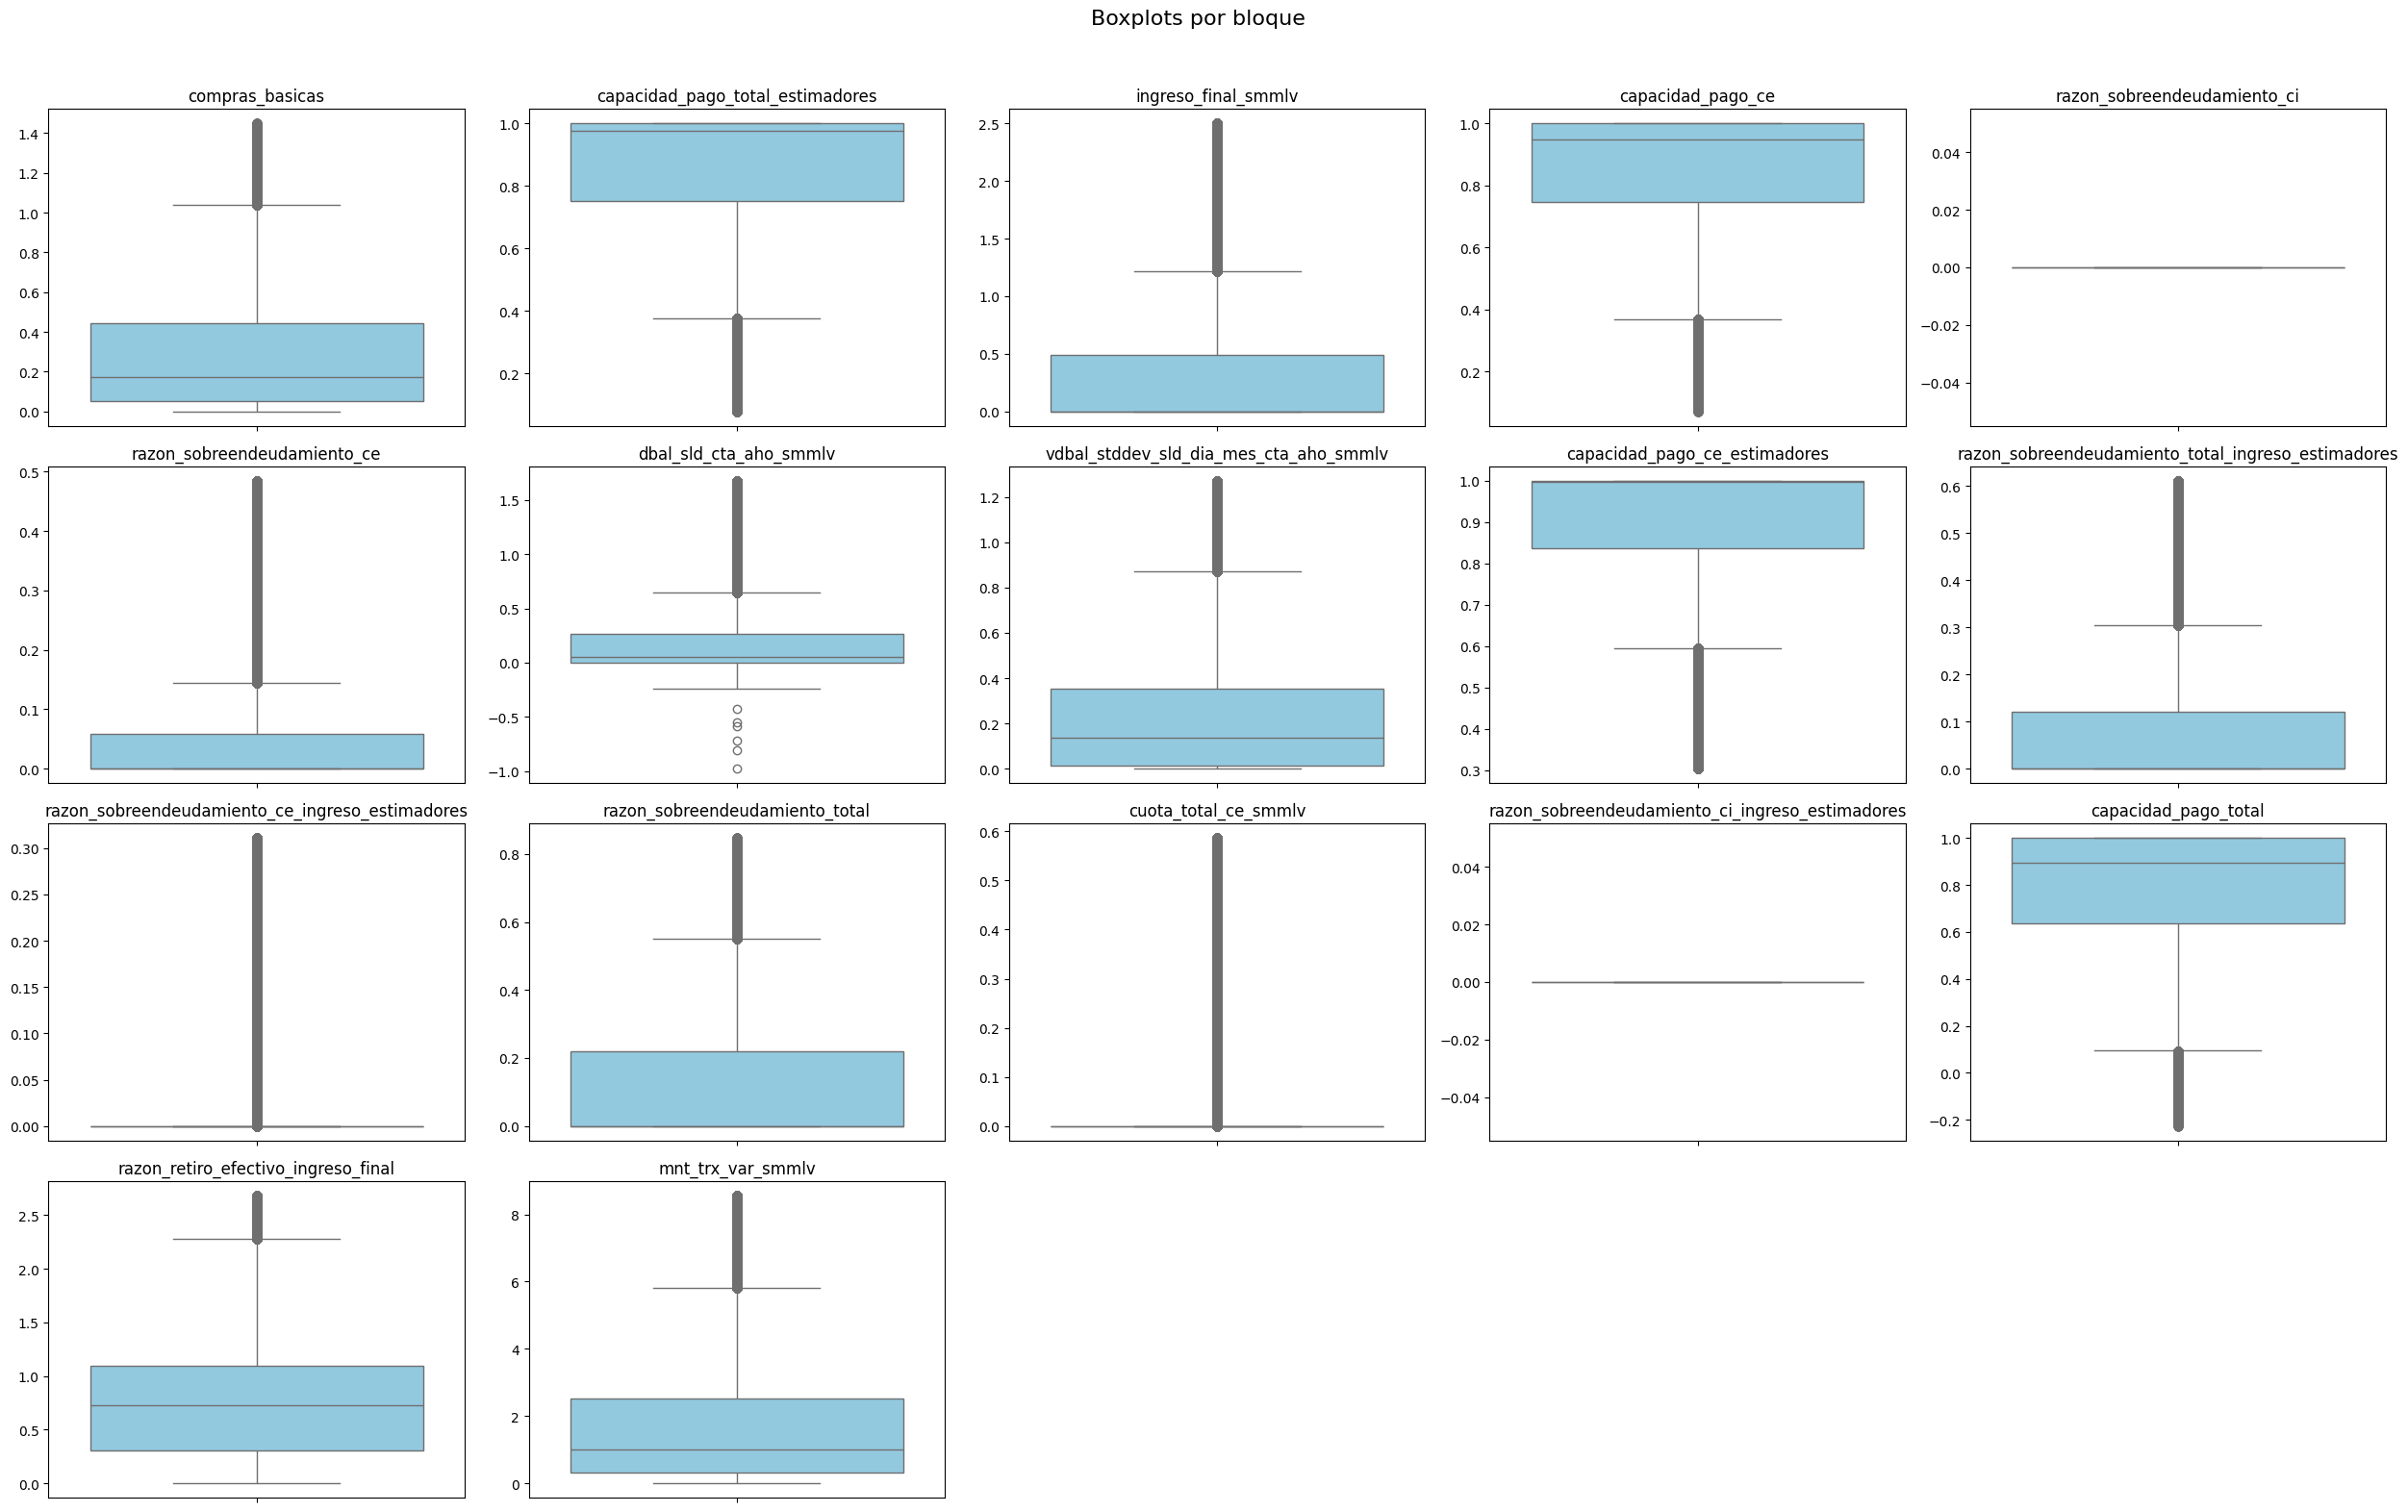

In [62]:
graficar_boxplots_por_bloques(
    df=df_outliers_nan,
    columnas=columnas_numericas,
    n_cols=5,
    por_bloque=17
)

### Análisis de boxplots luego del tratamiento de nulos y outliers

Luego de reemplazar los valores atípicos por nulos, los boxplots muestran una distribución más centrada y simétrica en varias variables numéricas. Se observa una reducción notable de extremos y valores alejados del rango intercuartílico, lo cual indica que el tratamiento fue efectivo para mitigar la influencia de outliers. Sin embargo, algunas variables conservan asimetrías o dispersión alta, lo que sugiere la necesidad de escalado posterior o transformaciones adicionales en etapas de modelamiento. En general, el conjunto está en mejores condiciones para aplicar algoritmos sensibles a outliers o escalas.

### Exportación del dataset procesado por partes en .parquet

In [55]:
# Exportación del dataset final procesado
# df_outliers_nan.to_parquet("dataset_final_procesada.parquet")

In [ ]:
df_outliers_nan.shape

In [ ]:
# Proporciones de la variable respuesta (valor_g)
df_outliers_nan['valor_g'].value_counts(1)

In [ ]:
# Porcentaje de nulidad para la variable respuesta
df_outliers_nan['valor_g'].isnull().sum() / df_outliers_nan.shape[0]

In [ ]:
# Filtrar registros con valor_g no nulo
df_procesado = df_outliers_nan[df_outliers_nan['valor_g'].notna()]

In [ ]:
# Guardando en varios archivos la base de datos procesada

# Tamaño del chunk
chunk_size = 130_000
num_registros = len(df_procesado)
# Guardar cada parte
for i in range(0, num_registros, chunk_size):
    df_chunk = df_procesado.iloc[i:i+chunk_size]
    df_chunk.to_parquet(f'base_variables_procesada_parte{i}.parquet', index=False)

## Análisis descriptivos sobre 6 variables númericas

In [26]:
def graficar_hist_y_box_6(df, columnas, sample_size=20000):
    assert len(columnas) == 6, "Debes pasar exactamente 6 columnas."

    df_sample = df.sample(n=min(len(df), sample_size), random_state=42)

    fig, axes = plt.subplots(2, 6, figsize=(22, 8), gridspec_kw={'height_ratios': [3, 1]})

    for i, col in enumerate(columnas):
        sns.histplot(df_sample[col].dropna(), bins=50, kde=False, ax=axes[0, i], color="orange", edgecolor="black")
        axes[0, i].set_title(col)
        axes[0, i].set_xlabel("")
        axes[0, i].set_ylabel("")

        sns.boxplot(x=df_sample[col].dropna(), ax=axes[1, i], color="orange", orient='h')

        axes[1, i].set_xlabel("")
        axes[1, i].set_ylabel("")

    plt.tight_layout()
    plt.savefig("hist_boxplots_procesada.png", dpi=300, bbox_inches='tight')
    plt.show()


In [27]:
columnas_seleccionadas = ['razon_sobreendeudamiento_total', 'capacidad_pago_total', 'razon_compras_no_basicas', 
 'valor_ingreso_estimadores_smmlv', 'dbal_sld_cta_aho_smmlv', 'dias_mora']

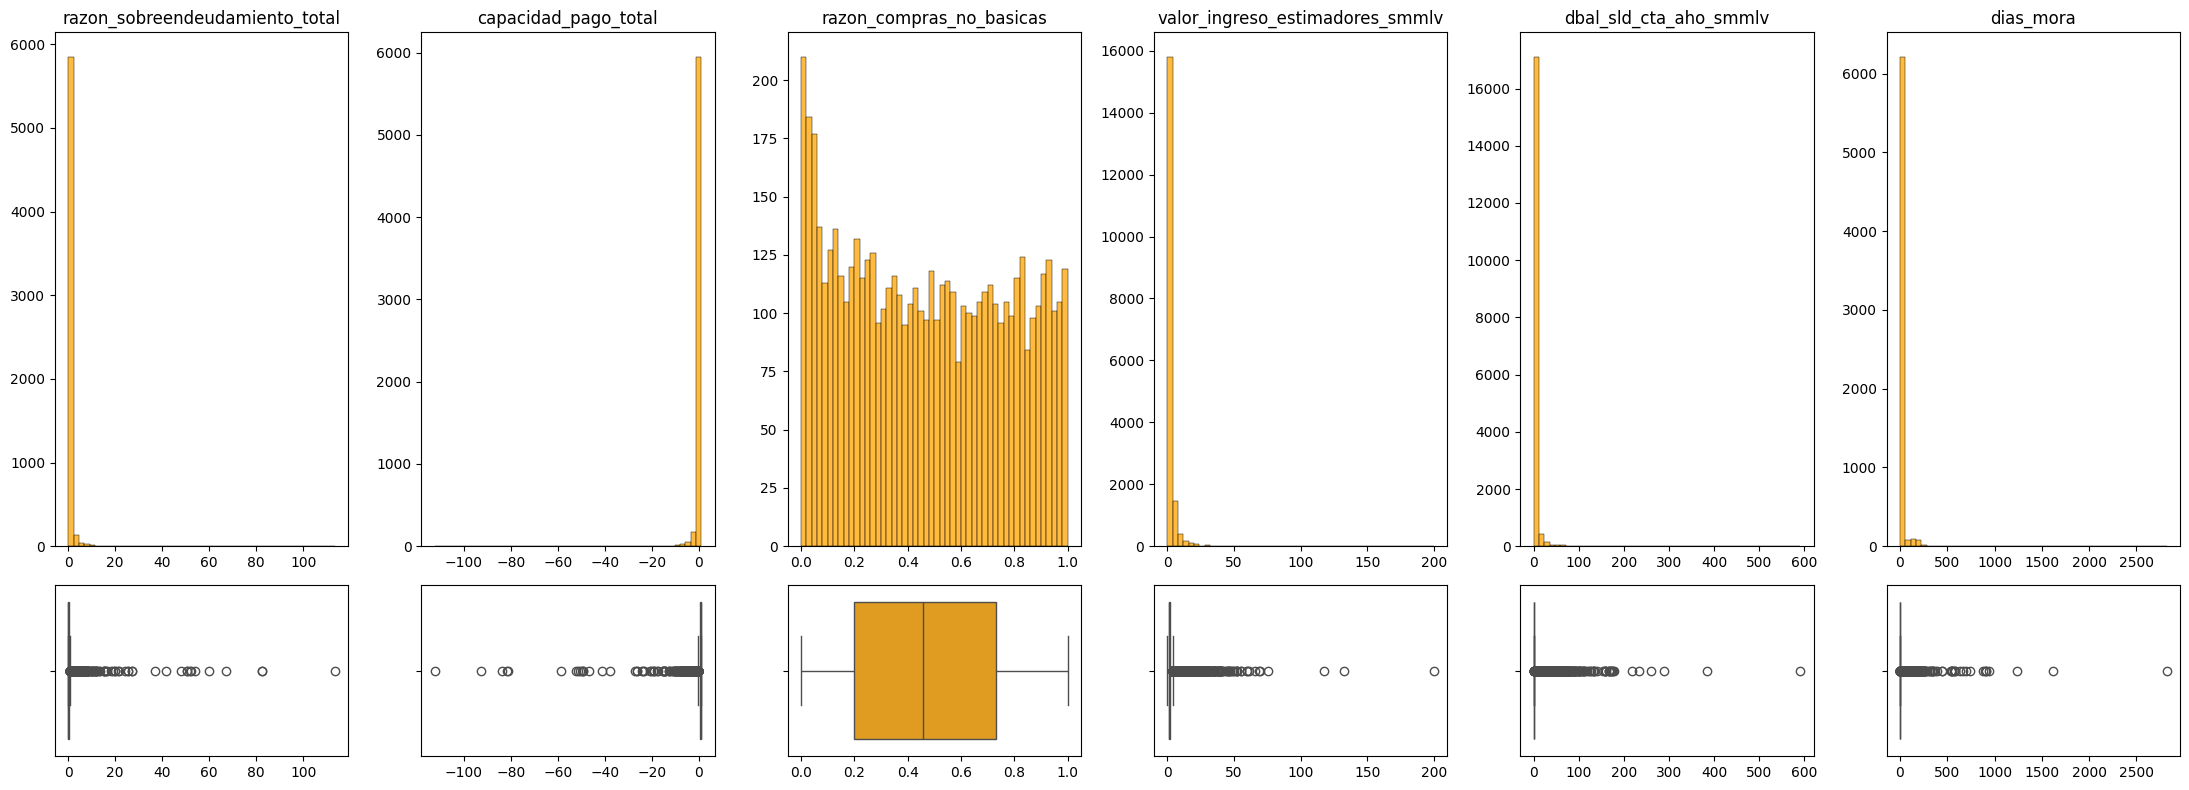

In [20]:
graficar_hist_y_box_6(
    df_final[columnas_seleccionadas],
    columnas_seleccionadas)

In [24]:
# Misma grafica con la base final procesada

In [25]:
df_procesado.shape

(1284505, 68)

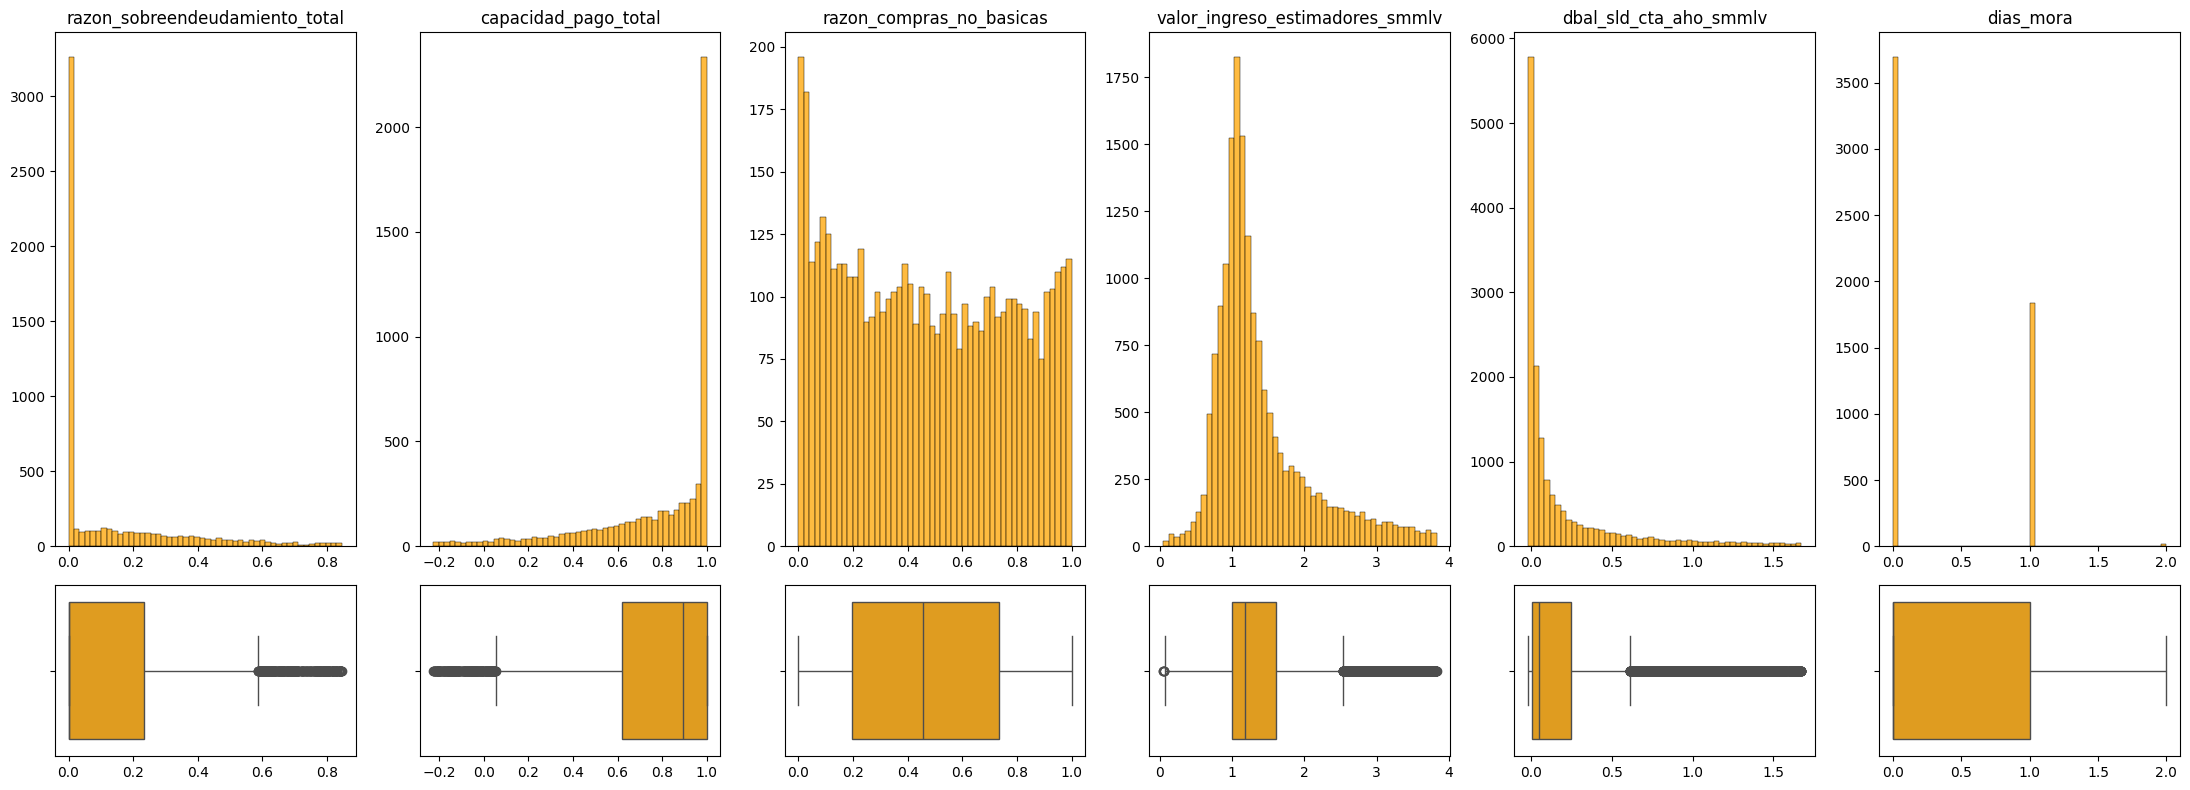

In [28]:
graficar_hist_y_box_6(
    df_procesado[columnas_seleccionadas],
    columnas_seleccionadas)

## Análisis descriptivos sobre 3 variables dicotomicas

In [37]:
def graficar_barras_dicotomicas(df, columnas):
    assert len(columnas) == 3, "Debes pasar exactamente 3 columnas."

    plt.figure(figsize=(15, 4))
    for i, col in enumerate(columnas):
        plt.subplot(1, 3, i + 1)
        sns.countplot(x=col, hue=col, data=df, palette="pastel", legend=False)
        plt.title(f"Frecuencia de {col}")
        plt.xlabel("")
        plt.ylabel("Conteo")
        plt.xticks([0, 1], ["0", "1"])

    plt.tight_layout()
    plt.savefig("barras_dicotomicas.png", dpi=300, bbox_inches='tight')
    plt.show()


In [33]:
columnas_seleccionadas = ['flag_inversiones', 'flag_capacidad_pago_total', 'flag_cliente_ahorra']

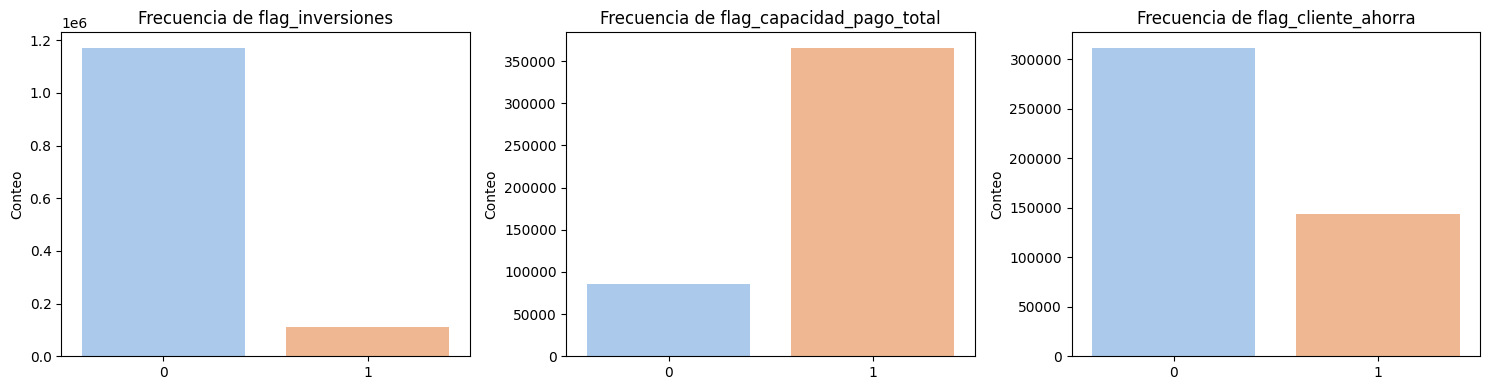

In [38]:
graficar_barras_dicotomicas(
    df_procesado[columnas_seleccionadas],
    columnas_seleccionadas
)

## Análisis de correlación de las 6 variables númericas y el valor_g

In [48]:
def graficar_matriz_correlacion(df, columnas, metodo="spearman"):
    assert len(columnas) >= 2, "Debes pasar al menos dos columnas."

    df_corr = df[columnas].dropna()
    matriz_corr = df_corr.corr(method=metodo)

    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                linewidths=0.5, square=True, cbar_kws={"label": f"Correlación ({metodo})"})
    plt.title("Matriz de Correlación")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [49]:
columnas_seleccionadas = ['razon_sobreendeudamiento_total', 'capacidad_pago_total', 'razon_compras_no_basicas', 
 'valor_ingreso_estimadores_smmlv', 'dbal_sld_cta_aho_smmlv', 'dias_mora']

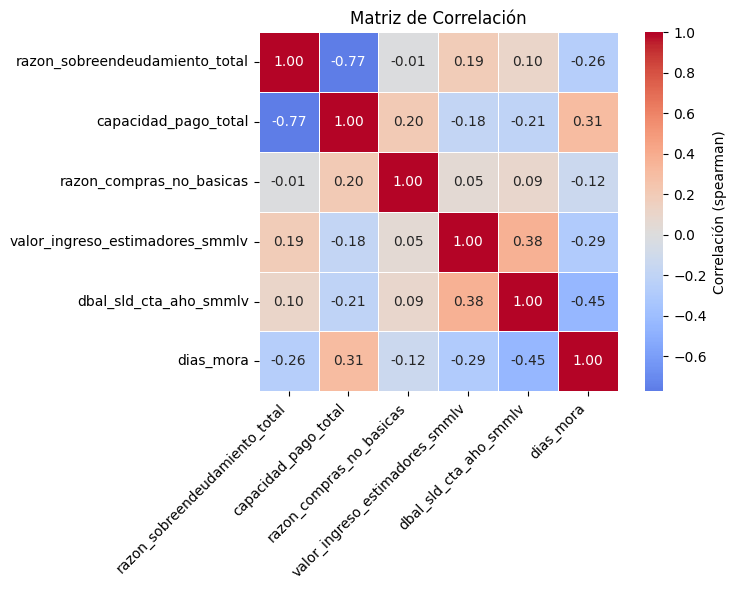

In [50]:
graficar_matriz_correlacion(
    df_procesado,
    columnas_seleccionadas)

In [53]:
def matriz_correlacion_con_valor_g(df, variables, metodo="spearman"):
    df_corr = df.copy()
    df_corr["valor_g_ordinal"] = df_corr["valor_g"].map({f"G{i}": i for i in range(1, 9)})

    columnas = variables + ["valor_g_ordinal"]
    matriz = df_corr[columnas].corr(method=metodo)

    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True,
                linewidths=0.5, cbar_kws={"label": f"Correlación ({metodo})"})
    plt.title("Matriz de correlación con valor_g (ordinal)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("matriz_correlacion.png", dpi=300, bbox_inches='tight')
    plt.show()


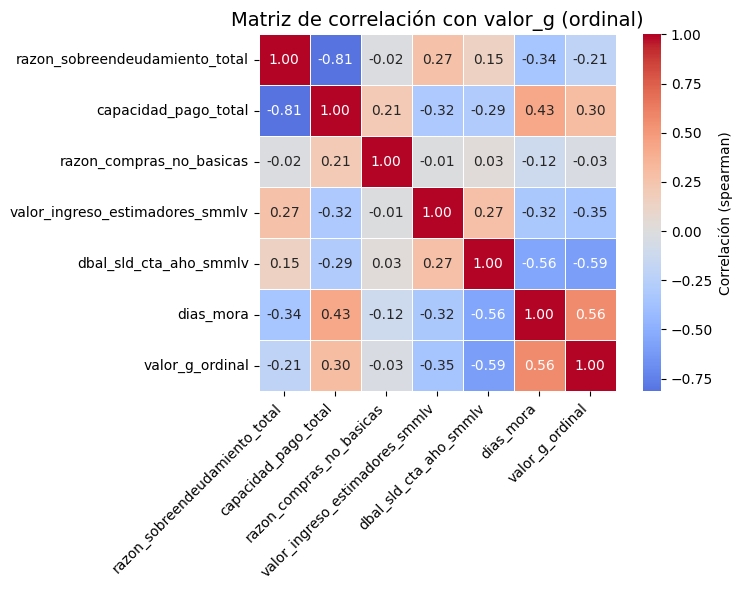

In [54]:
matriz_correlacion_con_valor_g(df_procesado, columnas_seleccionadas)

### Conclusión final

Antes de la preparación del dataset final, se aplicaron filtros clave para acotar la información: se conservaron únicamente los registros comprendidos entre agosto de 2021 y marzo de 2025, correspondientes a clientes activos, personas naturales y segmentos relevantes para el análisis. Posteriormente, durante el proceso de limpieza y preparación de datos, se identificaron y trataron problemas como duplicidad de registros por cliente y fecha, aplicando funciones de agregación y filtros DISTINCT para conservar solo combinaciones únicas. En la etapa de preparación final, se realizó un análisis de duplicidad que permitió eliminar más de 62 mil registros repetidos, y un análisis de valores atípicos (outliers), los cuales fueron reemplazados por valores nulos con el fin de preservar la mayor cantidad posible de información útil sin distorsionar la distribución de los datos. Además, se eliminaron seis variables tipo flag completamente vacías y seis variables numéricas que superaban el 80% de nulidad y cuya relevancia para el negocio era limitada. Aunque algunas variables aún presentan altos niveles de nulidad, se conservaron aquellas consideradas fundamentales para el negocio, ya que en etapas futuras se utilizarán modelos que permiten tratar estos valores faltantes de forma adecuada. Como resultado, se redujo el tamaño del dataset de 203.6MB a 164MB, optimizando su uso sin sacrificar información crítica.


### Carga de la base de datos procesada

In [21]:
# Lista vacía para guardar los DataFrames
dfs_p = []

# Leer archivos del 0 al 9 y agregarlos a la lista
for i in range(10):
    file_name = f"base_variables_procesada_parte{i}.parquet"
    df = pd.read_parquet(file_name)
    dfs_p.append(df)

In [22]:
df_procesado = pd.concat(dfs_p, ignore_index=True)

In [23]:
df_procesado.shape

(1284505, 68)

### Separación del conjunto de datos en Train y Test

In [53]:
from sklearn.model_selection import train_test_split

# División 70% entrenamiento, 30% validación con estratificación
df_train, df_test = train_test_split(
    df_procesado,
    test_size=0.3,
    stratify=df_procesado['valor_g'],
    random_state=42
)

In [54]:
# Verificación opcional de la distribución por clase
print("Distribución en train:")
print(df_train['valor_g'].value_counts(normalize=True))

Distribución en train:
valor_g
G7    0.238839
G8    0.138481
G5    0.125976
G1    0.111966
G4    0.105277
G6    0.104978
G3    0.091118
G2    0.083364
Name: proportion, dtype: float64


In [55]:
print("\nDistribución en test:")
print(df_test['valor_g'].value_counts(normalize=True))


Distribución en test:
valor_g
G7    0.238839
G8    0.138481
G5    0.125976
G1    0.111968
G4    0.105275
G6    0.104979
G3    0.091117
G2    0.083365
Name: proportion, dtype: float64


In [ ]:
# Separar variable objetivo y variables predictoras
X_train = df_train.drop(columns=["valor_g"])
y_train = df_train["valor_g"]

X_test = df_test.drop(columns=["valor_g"])
y_test = df_test["valor_g"]